# 데이터 전처리

In [ ]:
import pandas as pd
import os

def remove_extreme_outliers(file_path, save_path=None):
    print(f"📂 파일 로딩 중: {file_path}")
    df = pd.read_excel(file_path)
    original_len = len(df)

    # 1. 검사할 컬럼 지정 (온도 센서들)
    # 문제가 되었던 VFD 온도 센서들만 타겟으로 잡습니다.
    target_cols = [
        'Q_VFD1_Temperature',
        'Q_VFD2_Temperature',
        'Q_VFD3_Temperature',
        'Q_VFD4_Temperature'
    ]

    # 실제 존재하는 컬럼만 필터링
    exist_cols = [col for col in target_cols if col in df.columns]

    if not exist_cols:
        print("⚠️ 타겟 컬럼(온도 센서)이 데이터에 없습니다. 스킵합니다.")
        return

    # 2. 임계값 설정
    MAX_THRESHOLD = 10000    # 9억 같은 너무 큰 값 제거
    MIN_THRESHOLD = 0.001    # 1e-38 같은 너무 작은 값(0 포함) 제거

    # 3. 삭제 로직 (하나라도 범위를 벗어나면 그 행 삭제)
    # 조건: (값이 10000 초과) OR (값이 0.001 미만)
    # 주의: 판다스에서는 'or' 대신 '|' 연산자를 써야 하며, 괄호로 묶어야 합니다.
    outlier_mask = ((df[exist_cols] > MAX_THRESHOLD) | (df[exist_cols] < MIN_THRESHOLD)).any(axis=1)

    # 정상 데이터만 남기기 (~outlier_mask)
    clean_df = df[~outlier_mask]

    # 4. 결과 출력
    removed_count = original_len - len(clean_df)
    print(f"   - 전체 데이터: {original_len}개")
    print(f"   - 삭제된 이상치 행: {removed_count}개")
    print(f"     (삭제 조건: 값 > {MAX_THRESHOLD} 또는 값 < {MIN_THRESHOLD})")
    print(f"   - 남은 데이터: {len(clean_df)}개")

    # 5. 엑셀 저장
    if save_path is None:
        save_path = file_path.replace(".xlsx", "_cleaned.xlsx")

    print(f"💾 저장 중... -> {save_path}")
    clean_df.to_excel(save_path, index=False)
    print("✅ 완료!\n")

# --- 실행 부분 ---
train_file = "/content/preproc_train_data_final.xlsx"
val_file = "/content/preproc_val_data_final.xlsx"
test_file = "/content/preproc_test_data_final.xlsx"

if os.path.exists(train_file): remove_extreme_outliers(train_file)
else: print(f"❌ 파일을 찾을 수 없습니다: {train_file}")

if os.path.exists(val_file): remove_extreme_outliers(val_file)
else: print(f"❌ 파일을 찾을 수 없습니다: {val_file}")

if os.path.exists(test_file): remove_extreme_outliers(test_file)
else: print(f"❌ 파일을 찾을 수 없습니다: {test_file}")

📂 파일 로딩 중: /content/preproc_train_data_final.xlsx
   - 전체 데이터: 80088개
   - 삭제된 이상치 행: 1253개
     (삭제 조건: 값 > 10000 또는 값 < 0.001)
   - 남은 데이터: 78835개
💾 저장 중... -> /content/preproc_train_data_final_cleaned.xlsx
✅ 완료!

📂 파일 로딩 중: /content/preproc_val_data_final.xlsx
   - 전체 데이터: 12919개
   - 삭제된 이상치 행: 205개
     (삭제 조건: 값 > 10000 또는 값 < 0.001)
   - 남은 데이터: 12714개
💾 저장 중... -> /content/preproc_val_data_final_cleaned.xlsx
✅ 완료!

📂 파일 로딩 중: /content/preproc_test_data_final.xlsx
   - 전체 데이터: 12949개
   - 삭제된 이상치 행: 206개
     (삭제 조건: 값 > 10000 또는 값 < 0.001)
   - 남은 데이터: 12743개
💾 저장 중... -> /content/preproc_test_data_final_cleaned.xlsx
✅ 완료!



# CVAE-ANP 훈련

## 드라이브 마운트

In [ ]:
# 1. 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 압축 해제

In [ ]:
#데이터 압축 파일 해제
import tarfile # zipfile 대신 tarfile 임포트
import os

def unzip_to_content(zip_path, out_dir="/content"):
    assert os.path.exists(zip_path), f"File not found: {zip_path}"
    print(f"[EXTRACTING] {zip_path} → {out_dir}")

    # 파일 확장자에 따라 다른 모듈 사용
    if zip_path.lower().endswith(('.zip')):
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(out_dir)
    elif zip_path.lower().endswith(('.tar', '.gz', '.tgz', '.bz2')):
        with tarfile.open(zip_path, 'r') as tf:
            tf.extractall(out_dir)
    else:
        raise ValueError(f"Unsupported archive format: {zip_path}")
    print("[DONE]")

# ===== 압축 파일 경로 =====
ZIP_FILES = [
    "/content/drive/MyDrive/FF_Dataset/Final.tar"
]

for zp in ZIP_FILES:
    unzip_to_content(zp)


[EXTRACTING] /content/drive/MyDrive/FF_Dataset/Final.tar → /content


/tmp/ipython-input-1473144184.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall(out_dir)


[DONE]


## 모델 불러오기

In [ ]:
import sys

# 'VAE_ANP' 폴더가 있는 부모 디렉토리의 경로를 지정하세요.
# 예: 만약 VAE_ANP 폴더가 '내 드라이브/my_project/VAE_ANP'에 있다면,
# project_root_path = '/content/drive/My Drive/my_project'
project_root_path = '/content/drive/My Drive/VAE_ANP/' # VAE_ANP 폴더 자체가 sys.path에 추가되도록 수정

# sys.path에 경로 추가
if project_root_path not in sys.path:
    sys.path.append(project_root_path)
    print(f"'{project_root_path}' 경로가 sys.path에 추가되었습니다.")
else:
    print(f"'{project_root_path}' 경로는 이미 sys.path에 있습니다.")

# 추가된 경로 확인 (선택 사항)
print("Current sys.path:")
for p in sys.path:
    print(p)

'/content/drive/My Drive/VAE_ANP/' 경로가 sys.path에 추가되었습니다.
Current sys.path:
/content
/env/python
/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/usr/local/lib/python3.12/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.12/dist-packages/IPython/extensions
/root/.ipython
/content/drive/My Drive/VAE_ANP/


## 패키지 설치

In [ ]:
!pip install pytorch-lightning
!pip install optuna

## 훈련 데이터 설정

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import joblib
import os
import ast
import optuna
from optuna.trial import TrialState
import argparse

# 모델을 가져옵니다.
# from combined_model_log import AttentiveCVAEANP
from ANP.anp_attn_log import NeuralProcess
from VAE.cvae_v2_fix import ConditionalVAE_v2

# 클래스 재정의 (수정본)
class AttentiveCVAEANP(nn.Module):
    def __init__(self, cvae_latent_dim, condition_dim, x_dim, hidden_dim, anp_latent_dim,
                 img_size=256, beta=1.0, **kwargs): # [수정] **kwargs 추가
        super().__init__()
        self.beta = beta

        # 1. CVAE (기존 동일)
        self.cvae = ConditionalVAE_v2(in_channels=3,
                                      condition_dim=condition_dim,
                                      latent_dim=cvae_latent_dim,
                                      img_size=img_size)

        image_feature_dim = self.cvae.hidden_dims[-1]

        # 2. ANP (수정됨)
        # 여기서 **kwargs를 통해 min_std, dropout 등을 NeuralProcess로 전달합니다.
        self.anp = NeuralProcess(x_dim=x_dim,
                                 y_dim=1,
                                 hidden_dim=hidden_dim,
                                 latent_dim=anp_latent_dim,
                                 latent_enc_self_attn_type="ptmultihead",
                                 det_enc_self_attn_type="ptmultihead",
                                 det_enc_cross_attn_type="ptmultihead",
                                 image_attention_type="ptmultihead",
                                 use_self_attn=True,
                                 global_context_dim=cvae_latent_dim,
                                 image_feature_dim=image_feature_dim,
                                 **kwargs) # [핵심] 나머지 인자들(min_std, dropout)을 ANP로 전달!

    def forward(self, image, condition, context_x, context_y, target_x, target_y=None):
        # Forward 로직은 기존과 100% 동일
        cvae_output = self.cvae(image, condition=condition)
        img_mu = cvae_output[2]
        features = cvae_output[4]

        cvae_loss_dict = self.cvae.loss_function(*cvae_output[:4])

        if 'Reconstruction_Loss' in cvae_loss_dict and 'KLD' in cvae_loss_dict:
            cvae_loss_dict['loss'] = cvae_loss_dict['Reconstruction_Loss'] + self.beta * cvae_loss_dict['KLD']

        _, anp_loss_dict, anp_misc_outputs, latent_self_attn, image_cross_attn, det_attn_weights = self.anp(
            context_x,
            context_y,
            target_x,
            target_y,
            global_context=img_mu,
            image_features=features
        )

        return anp_misc_outputs['y_dist'], anp_loss_dict, cvae_loss_dict, latent_self_attn, image_cross_attn, det_attn_weights, img_mu

# --- 전역 상수 및 설정 ---
IMG_DIRS = [
    "/content/Final/Image/train/BATCH1000", "/content/Final/Image/train/BATCH2000",
    "/content/Final/Image/train/BATCH3000", "/content/Final/Image/train/BATCH4000",
    "/content/Final/Image/train/BATCH5000", "/content/Final/Image/train/BATCH6000",
    "/content/Final/Image/train/BATCH7000", "/content/Final/Image/train/BATCH8000",
    "/content/Final/Image/train/BATCH9000", "/content/Final/Image/train/BATCH10000",
    "/content/Final/Image/train/BATCH11000", "/content/Final/Image/train/BATCH12000",
    "/content/Final/Image/train/BATCH13000", "/content/Final/Image/train/BATCH14000",
    "/content/Final/Image/train/BATCH15000", "/content/Final/Image/train/BATCH16000",
    "/content/Final/Image/train/BATCH17000", "/content/Final/Image/train/BATCH18000",
    "/content/Final/Image/train/BATCH19000", "/content/Final/Image/val/BATCH20000",
    "/content/Final/Image/val/BATCH21000", "/content/Final/Image/val/BATCH22000"
]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_RESOLUTION = 256
ORIGINAL_IMG_DIMS = (1080, 720)
X_DIM = 2
BEST_MODEL_SAVE_PATH = "/content/drive/MyDrive/ResultCA/best_cvae_anp_model.pth"
SCALER_SAVE_PATH = "/content/drive/MyDrive/ResultCA/anp_scaler.joblib"
BEST_ATTENTION_SAVE_PATH = "/content/drive/MyDrive/ResultCA/best_attention_weights.pt"
TRAIN_DATA_PATH = "/content/preproc_train_data_final.xlsx"
VAL_DATA_PATH = "/content/preproc_val_data_final.xlsx"
PREPROC_DATA_SAVE_PATH = "/content/preproc_data.xlsx"

def get_args():
    parser = argparse.ArgumentParser(description="Train CVAE-ANP Model")
    parser.add_argument('--clip', type=float, default=1.0, help='Gradient clipping value.')
    parser.add_argument('--anp_loss_weight', type=float, default=1.0, help='Weight for ANP loss.')
    parser.add_argument('--cvae_loss_weight', type=float, default=1.0, help='Weight for CVAE loss.')
    return parser.parse_args()

# --- 2D 좌표계 설정 ---
COMPONENT_ORDER = ['MHS', 'R01', 'R02', 'R03', 'R04', 'Conv1', 'Conv2', 'Conv3', 'Conv4']

COMPONENT_COORDS_0 = {
    'MHS': {'h': 53, 'w': 183, 'x1': 232, 'x2': 415, 'y1': 182, 'y2': 235},
    'R01': {'h': 160, 'w': 99, 'x1': 385, 'x2': 484, 'y1': 102, 'y2': 262},
    'R02': {'h': 148, 'w': 140, 'x1': 273, 'x2': 413, 'y1': 143, 'y2': 291},
    'R03': {'h': 187, 'w': 173, 'x1': 372, 'x2': 545, 'y1': 161, 'y2': 348},
    'R04': {'h': 139, 'w': 131, 'x1': 173, 'x2': 304, 'y1': 145, 'y2': 284},
    'Conv1': {'h': 158, 'w': 334, 'x1': 414, 'x2': 748, 'y1': 362, 'y2': 520},
    'Conv2': {'h': 139, 'w': 346, 'x1': 380, 'x2': 726, 'y1': 210, 'y2': 349},
    'Conv3': {'h': 43, 'w': 225, 'x1': 131, 'x2': 356, 'y1': 228, 'y2': 271},
    'Conv4': {'h': 294, 'w': 380, 'x1': 91, 'x2': 471, 'y1': 268, 'y2': 562}
}
COMPONENT_COORDS_1 = {
    'MHS': {'h': 251, 'w': 397, 'x1': 363, 'x2': 760, 'y1': 278, 'y2': 529},
    'R01': {'h': 439, 'w': 227, 'x1': 199, 'x2': 426, 'y1': 124, 'y2': 563},
    'R02': {'h': 187, 'w': 128, 'x1': 379, 'x2': 507, 'y1': 108, 'y2': 295},
    'R03': {'h': 148, 'w': 120, 'x1': 287, 'x2': 407, 'y1': 106, 'y2': 254},
    'R04': {'h': 264, 'w': 268, 'x1': 589, 'x2': 857, 'y1': 164, 'y2': 428},
    'Conv1': {'h': 39, 'w': 183, 'x1': 179, 'x2': 362, 'y1': 178, 'y2': 217},
    'Conv2': {'h': 182, 'w': 301, 'x1': 168, 'x2': 469, 'y1': 208, 'y2': 390},
    'Conv3': {'h': 81, 'w': 215, 'x1': 457, 'x2': 672, 'y1': 264, 'y2': 345},
    'Conv4': {'h': 106, 'w': 338, 'x1': 354, 'x2': 692, 'y1': 173, 'y2': 279}
}

## 데이터 로드 함수 지정

In [ ]:
def map_sensor_to_component(sensor_name):
    for component in sorted(COMPONENT_ORDER, key=len, reverse=True):
        if component in sensor_name: return component
    return 'Conv' if 'Conv' in sensor_name else None

def create_sensor_coord_tensor(sensor_keys, coord_type):
    coords_map = COMPONENT_COORDS_1 if coord_type == 1 else COMPONENT_COORDS_0
    coords = []
    w, h = ORIGINAL_IMG_DIMS
    for key in sensor_keys:
        component_name = map_sensor_to_component(key)
        if component_name and component_name in coords_map:
            box = coords_map[component_name]
            coords.append([(box['x1'] + box['x2']) / 2.0 / w, (box['y1'] + box['y2']) / 2.0 / h])
        else:
            coords.append([0.0, 0.0]) # 매핑 불가 시 기본값
    return torch.tensor(coords, dtype=torch.float32)

# --- [수정] 데이터셋 클래스 ---
class CombinedANPDataset(Dataset):
    def __init__(self, features_df, mask_df, image_paths_series, labels_series,
                 coord_tensor_0, coord_tensor_1, num_context_range, is_train=True):
        super().__init__()

        self.features = torch.tensor(np.array(features_df).astype(np.float32), dtype=torch.float32)
        self.masks = torch.tensor(mask_df.values, dtype=torch.bool)
        self.labels = torch.tensor(labels_series.values, dtype=torch.float32)
        self.x_all_0 = coord_tensor_0
        self.x_all_1 = coord_tensor_1

        self.img_path_map = {os.path.basename(f): os.path.join(d, f) for d in IMG_DIRS if os.path.isdir(d) for f in os.listdir(d) if f.lower().endswith(('.png', '.jpg', '.jpeg'))}
        self.samples = [{'df_idx': df_idx, 'img_filename': os.path.basename(fn)} for df_idx, img_paths_str in enumerate(image_paths_series.values) for fn in (ast.literal_eval(img_paths_str) if isinstance(img_paths_str, str) else []) if os.path.basename(fn) in self.img_path_map]

        self.num_context_range = num_context_range
        self.transform = transforms.Compose([transforms.Resize((IMAGE_RESOLUTION, IMAGE_RESOLUTION)), transforms.ToTensor(), transforms.Normalize([0.5] * 3, [0.5] * 3)])
        print(f"Dataset initialized with {len(self.samples)} samples.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_info = self.samples[idx]
        df_idx, img_filename = sample_info['df_idx'], sample_info['img_filename']
        y_sensors, sensor_mask, label = self.features[df_idx], self.masks[df_idx], self.labels[df_idx]

        try:
            full_img_path = self.img_path_map[img_filename]
            img_tensor = self.transform(Image.open(full_img_path).convert("RGB"))
        except Exception as e:
            print(f"Skipping corrupted or missing file: {img_filename}. Error: {e}")
            return None

        coord_tensor_to_use = self.x_all_1 if img_filename.endswith("_1.png") else self.x_all_0

        valid_indices = torch.where(sensor_mask)[0]
        if len(valid_indices) < self.num_context_range[0]: return None

        num_context_total = min(np.random.randint(*self.num_context_range), len(valid_indices))
        shuffled_indices = valid_indices[torch.randperm(len(valid_indices))]
        context_indices = shuffled_indices[:num_context_total]
        target_indices = valid_indices # Target은 모든 유효한 센서를 사용

        # --- [수정된 로직] 컨텍스트 포인트를 img_context와 num_context로 분리 ---
        # 실제 좌표값이 있는 (0,0이 아닌) 센서를 'img_context'로, 그렇지 않은 센서를 'num_context'로 분류합니다.
        context_x_all = coord_tensor_to_use[context_indices]
        context_y_all = y_sensors[context_indices].unsqueeze(-1)

        # 좌표가 (0,0)이 아닌 경우 True인 마스크 생성
        is_img_context_mask = torch.any(context_x_all != 0, dim=1)

        img_context_x = context_x_all[is_img_context_mask]
        img_context_y = context_y_all[is_img_context_mask]

        num_context_x = context_x_all[~is_img_context_mask]
        num_context_y = context_y_all[~is_img_context_mask]
        # --- [로직 수정 끝] ---

        target_x, target_y = coord_tensor_to_use[target_indices], y_sensors[target_indices].unsqueeze(-1)
        sensor_summary = y_sensors[sensor_mask].mean().unsqueeze(0) if len(valid_indices) > 0 else torch.tensor([0.0])

        return {'num_context_x': num_context_x, 'num_context_y': num_context_y,
                'img_context_x': img_context_x, 'img_context_y': img_context_y,
                'target_x': target_x, 'target_y': target_y, 'image': img_tensor,
                'label': label, 'sensor_summary': sensor_summary,
                'target_mask': sensor_mask[target_indices]}

# --- [수정] 데이터 로더 ---
def collate_fn(batch):
    batch = [item for item in batch if item is not None];
    if not batch: return None
    collated = {}
    # num_context, img_context, target을 모두 처리
    for part in ['num_context', 'img_context', 'target']:
        for dim in ['x', 'y']:
            key = f'{part}_{dim}'; tensors = [item[key] for item in batch]
            collated[key] = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True, padding_value=0.0)

    collated['image'] = torch.stack([item['image'] for item in batch])
    collated['label'] = torch.stack([item['label'] for item in batch])
    collated['sensor_summary'] = torch.stack([item['sensor_summary'] for item in batch])
    collated['target_mask'] = torch.nn.utils.rnn.pad_sequence([item['target_mask'] for item in batch], batch_first=True, padding_value=False)
    return collated

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import joblib

def preprocess_dataframe(df: pd.DataFrame):
    print("--- [최종] 전처리: 청소 + 보간(ffill/bfill) + 차분 + StandardScaler ---")

    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
        df = df.sort_values('time').reset_index(drop=True)

    ignore_cols = ['time', 'Images', 'label', 'file_num']
    sensor_keys = [col for col in df.columns if col not in ignore_cols]

    # 1. Float 변환 & 물리적 이상치 제거
    for col in sensor_keys:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)

        # 10000 넘는 값 제거
        mask_too_big = df[col] > 10000
        if mask_too_big.sum() > 0: df.loc[mask_too_big, col] = np.nan

        # 미세 값 0 처리
        mask_too_small = df[col].abs() < 1e-4
        if mask_too_small.sum() > 0: df.loc[mask_too_small, col] = 0.0

    # 2. [보간] 차분 전에 매끄럽게 메꾸기 (학습/검증 동일!)
    # 앞뒤 값으로 채우고(ffill, bfill), 정 없으면 0으로 채움
    df[sensor_keys] = df[sensor_keys].ffill().bfill().fillna(0)

    # 3. [차분] 속도(변화량) 계산
    # 차분 후 첫 행은 NaN이 되므로 0으로 채움
    df[sensor_keys] = df[sensor_keys].diff().fillna(0)

    # 4. 멈춘 센서 삭제 & 스케일링 준비
    normal_df = df[df['label'] == 0]
    target_df = normal_df if not normal_df.empty else df

    valid_sensor_keys = []
    drop_cols = []

    for col in sensor_keys:
        values = target_df[col].dropna()
        if len(values) == 0:
            drop_cols.append(col)
            continue

        std = np.std(values)
        if std == 0:
            drop_cols.append(col)
        else:
            valid_sensor_keys.append(col)

    print(f"  ❌ 삭제(완전 고정): {len(drop_cols)}개")
    print(f"  ✅ 적용(StandardScaler): {len(valid_sensor_keys)}개")

    # 5. StandardScaler 적용
    scaler = StandardScaler()
    if valid_sensor_keys:
        scaler.fit(target_df[valid_sensor_keys])
        df[valid_sensor_keys] = scaler.transform(df[valid_sensor_keys])

    # 6. 저장
    mask_df = (df[valid_sensor_keys] != 0)

    coord_tensor_0 = create_sensor_coord_tensor(valid_sensor_keys, coord_type=0)
    coord_tensor_1 = create_sensor_coord_tensor(valid_sensor_keys, coord_type=1)

    scaler_info = {
        'scaler': scaler,
        'valid_sensor_keys': valid_sensor_keys
    }
    joblib.dump(scaler_info, SCALER_SAVE_PATH)

    return df, mask_df, scaler_info, valid_sensor_keys, coord_tensor_0, coord_tensor_1


def process_validation_data(df: pd.DataFrame, scaler_info, sensor_keys_unused=None):

    if isinstance(scaler_info, dict):
        scaler = scaler_info['scaler']
        final_sensor_keys = scaler_info['valid_sensor_keys']
    else:
        raise ValueError("Scaler Info Error")

    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
        df = df.sort_values('time').reset_index(drop=True)

    # 1. 컬럼 체크 (누락 시 에러)
    missing_cols = [col for col in final_sensor_keys if col not in df.columns]
    if missing_cols:
        raise ValueError(f"🚨 검증 데이터 컬럼 누락: {missing_cols}")

    df_val = df[final_sensor_keys].copy()

    # 2. Float 변환 & 청소
    for col in final_sensor_keys:
        df_val[col] = pd.to_numeric(df_val[col], errors='coerce').astype(float)

        mask_too_big = df_val[col] > 10000
        if mask_too_big.sum() > 0: df_val.loc[mask_too_big, col] = np.nan

        mask_too_small = df_val[col].abs() < 1e-4
        if mask_too_small.sum() > 0: df_val.loc[mask_too_small, col] = 0.0

    # 3. [보간] 학습 때와 100% 동일하게 적용
    # 앞뒤 값으로 채우고(ffill, bfill), 정 없으면 0으로 채움
    df_val[final_sensor_keys] = df_val[final_sensor_keys].ffill().bfill().fillna(0)

    # 4. [차분] 학습 때와 100% 동일하게 적용
    df_val[final_sensor_keys] = df_val[final_sensor_keys].diff().fillna(0)

    # 5. 스케일링 적용
    if final_sensor_keys:
        df_val[final_sensor_keys] = scaler.transform(df_val[final_sensor_keys])

    mask_df = (df_val[final_sensor_keys] != 0)

    return df_val, mask_df

## 최종 파라미터 설정

In [ ]:
LEARNING_RATE = 1e-5
EPOCHS = 50
BATCH_SIZE = 64
LATENT_DIM = 64
HIDDEN_DIM = 128
BETA = 5.0

## 훈련 함수 설정

In [ ]:
# --- 학습/평가 루프 ---
import torch
import numpy as np
from tqdm import tqdm

def run_epoch(model, dataloader, optimizer, device, clip_value, anp_loss_weight, cvae_loss_weight, is_train=True):
    model.train() if is_train else model.eval()
    total_loss, total_nll, total_cvae_loss = 0, 0, 0
    pbar = tqdm(dataloader, desc="Training" if is_train else "Evaluating", leave=False)

    last_batch_attention = None

    for batch in pbar:
        if batch is None: continue
        for key in batch: batch[key] = batch[key].to(device)
        if is_train: optimizer.zero_grad()

        # ====================================================
        # [Dynamic Context Splitting] - 원상복구 (Random Context)
        # ====================================================
        full_context_x = torch.cat((batch['num_context_x'], batch['img_context_x']), dim=1)
        full_context_y = torch.cat((batch['num_context_y'], batch['img_context_y']), dim=1)

        num_points = full_context_x.shape[1]

        # [수정] 다시 Random Context 로직으로 복귀
        # 학습 시: 랜덤하게 일부만 보여줌 (관계 학습 유도)
        # 평가 시: 여기서는 일단 Full을 쓰지만, extract_features에서 제어 가능
        if is_train:
            # 최소 3개 ~ 최대 전체 사이에서 랜덤
            num_context = np.random.randint(3, num_points + 1)
            indices = torch.randperm(num_points, device=device)
            context_idx = indices[:num_context]

            context_x = full_context_x[:, context_idx, :]
            context_y = full_context_y[:, context_idx, :]
            target_x = full_context_x
            target_y = full_context_y
        else:
            # 기본 검증(Validation) 루프에서는 Full Context 사용 (학습 진행상황 체크용)
            # *실제 이상탐지 성능 평가는 extract_features에서 마스킹 적용*
            context_x = full_context_x
            context_y = full_context_y
            target_x = full_context_x
            target_y = full_context_y

        # ====================================================
        # [모델 Forward]
        # ====================================================
        condition = torch.cat([batch['label'].unsqueeze(1), batch['sensor_summary']], dim=1)

        y_dist, anp_loss_dict, cvae_loss_dict, latent_attn, image_cross_attn, det_attn_weights = model(
            batch['image'], condition, context_x, context_y,
            target_x, target_y=target_y
        )

        # 손실 계산
        loss = anp_loss_weight * anp_loss_dict['loss'] + cvae_loss_weight * cvae_loss_dict['loss']
        nll = anp_loss_dict.get('loss_p', 0.0)
        cvae_loss = cvae_loss_dict.get('loss', 0.0)

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

        total_loss += loss.item(); total_nll += nll.item(); total_cvae_loss += cvae_loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}", nll=f"{nll.item():.4f}", cvae_loss=f"{cvae_loss.item():.4f}")

        if not is_train and image_cross_attn is not None:
            last_batch_attention = image_cross_attn.cpu().detach()

    avg_loss = total_loss / len(pbar) if len(pbar) > 0 else 0
    avg_nll = total_nll / len(pbar) if len(pbar) > 0 else 0
    avg_cvae = total_cvae_loss / len(pbar) if len(pbar) > 0 else 0

    return avg_loss, avg_nll, avg_cvae, last_batch_attention

# --- 메인 실행 함수 ---
def main_train():
    args = get_args()
    print(f"Using device: {DEVICE}")
    print(f"Hyperparameters: Clip={args.clip}, ANP Loss Weight={args.anp_loss_weight}, CVAE Loss Weight={args.cvae_loss_weight}")

    try:
        train_raw_df = pd.read_excel(TRAIN_DATA_PATH)
        val_raw_df = pd.read_excel(VAL_DATA_PATH)
    except FileNotFoundError as e: print(f"Error: 데이터 파일 없음 - {e}"); return

    train_df, train_mask, scaler, sensor_keys, coord_0, coord_1 = preprocess_dataframe(train_raw_df)
    # `val_df` will contain only sensor data. `val_raw_df` is needed for 'Images' and 'label'.
    val_df_processed, val_mask = process_validation_data(val_raw_df, scaler, sensor_keys)

    # 1. 훈련 데이터 강제 변환
    train_features_np = train_df[sensor_keys].to_numpy(dtype=np.float32)
    # 2. 검증 데이터 강제 변환
    val_features_np = val_df_processed[sensor_keys].to_numpy(dtype=np.float32)

    train_dataset = CombinedANPDataset(train_features_np, train_mask, train_raw_df['Images'], train_raw_df['label'],
                                       coord_0, coord_1, num_context_range=(10, 50))
    val_dataset = CombinedANPDataset(val_features_np, val_mask, val_raw_df['Images'], val_raw_df['label'],
                                     coord_0, coord_1, num_context_range=(10, 50), is_train=False)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

    model = AttentiveCVAEANP(cvae_latent_dim=LATENT_DIM, condition_dim=2,
                             x_dim=X_DIM, anp_latent_dim=LATENT_DIM,
                             hidden_dim=HIDDEN_DIM, beta = BETA,
                             img_size=IMAGE_RESOLUTION,
                             min_std = 0.01, dropout = 0.2).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-3)
    print(f"\nModel initialized on {DEVICE} with {sum(p.numel() for p in model.parameters()):,} parameters.")

    best_val_loss = float('inf')
    patience_limit = 5
    patience_counter = 0

    print("\n--- 모델 학습 시작 ---")
    for epoch in range(EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
        train_loss, train_nll, train_cvae_loss, _ = run_epoch(model, train_loader, optimizer, DEVICE, args.clip,
                                                              args.anp_loss_weight, args.cvae_loss_weight, is_train=True)
        with torch.no_grad():
            val_loss, val_nll, val_cvae_loss, last_attention = run_epoch(model, val_loader, None,
                                                                         DEVICE, args.clip, args.anp_loss_weight, args.cvae_loss_weight, is_train=False)

        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train -> Total: {train_loss:.4f} | NLL: {train_nll:.4f} | CVAE: {train_cvae_loss:.4f}")
        print(f"  Val   -> Total: {val_loss:.4f} | NLL: {val_nll:.4f} | CVAE: {val_cvae_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 # Reset patience
            torch.save(model.state_dict(), BEST_MODEL_SAVE_PATH)
            print(f"Validation loss improved. Model saved to {BEST_MODEL_SAVE_PATH}")

            if last_attention is not None:
                torch.save(last_attention, BEST_ATTENTION_SAVE_PATH)
                print(f"Attention weights for best model saved to {BEST_ATTENTION_SAVE_PATH}")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience_limit}")
            if patience_counter >= patience_limit:
                print("Early stopping triggered.")
                break
    print("\n--- Training Finished ---")

## 훈련

In [ ]:
import sys

# Save the original sys.argv
_original_sys_argv = sys.argv

# Temporarily set sys.argv to only the script name, ignoring Colab's internal arguments
sys.argv = [sys.argv[0]]

try:
    if __name__ == "__main__":
        main_train()
finally:
    # Restore sys.argv to its original state after main_train completes or an error occurs
    sys.argv = _original_sys_argv


Using device: cuda
Hyperparameters: Clip=1.0, ANP Loss Weight=1.0, CVAE Loss Weight=1.0
--- [최종] 전처리: 청소 + 보간(ffill/bfill) + 차분 + StandardScaler ---
  ❌ 삭제(완전 고정): 4개
  ✅ 적용(StandardScaler): 47개
Dataset initialized with 38002 samples.
Dataset initialized with 6000 samples.

Model initialized on cuda with 11,005,413 parameters.

--- 모델 학습 시작 ---

--- Epoch 1/50 ---


KeyboardInterrupt: 

# CVAE-ANP 테스트

## 분포 확인

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm

# 1. 모델 초기화 (기존 하이퍼파라미터 유지)
model = AttentiveCVAEANP(
    cvae_latent_dim=LATENT_DIM,
    condition_dim=2,
    x_dim=X_DIM,
    anp_latent_dim=LATENT_DIM,
    hidden_dim=HIDDEN_DIM,
    beta=BETA,
    img_size=IMAGE_RESOLUTION,
    min_std=0.01,
    dropout=0.2
).to(DEVICE)

# 2. 가중치 로드
if os.path.exists(BEST_MODEL_SAVE_PATH):
    state_dict = torch.load(BEST_MODEL_SAVE_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict)
    print(f"✅ 모델 가중치 로드 성공: {BEST_MODEL_SAVE_PATH}")
else:
    raise FileNotFoundError(f"가중치 파일 없음: {BEST_MODEL_SAVE_PATH}")

try:
    train_raw_df = pd.read_excel(TRAIN_DATA_PATH)
    val_raw_df = pd.read_excel(VAL_DATA_PATH)
except FileNotFoundError as e:
  print(f"Error: 데이터 파일 없음 - {e}")

train_df, train_mask, scaler, sensor_keys, coord_0, coord_1 = preprocess_dataframe(train_raw_df)
# `val_df` will contain only sensor data. `val_raw_df` is needed for 'Images' and 'label'.
val_df_processed, val_mask = process_validation_data(val_raw_df, scaler, sensor_keys)

# 1. 훈련 데이터 강제 변환
train_features_np = train_df[sensor_keys].to_numpy(dtype=np.float32)
# 2. 검증 데이터 강제 변환
val_features_np = val_df_processed[sensor_keys].to_numpy(dtype=np.float32)

train_dataset = CombinedANPDataset(train_features_np, train_mask, train_raw_df['Images'], train_raw_df['label'],
                                   coord_0, coord_1, num_context_range=(10, 50))
val_dataset = CombinedANPDataset(val_features_np, val_mask, val_raw_df['Images'], val_raw_df['label'],
                                 coord_0, coord_1, num_context_range=(10, 50), is_train=False)

# 3. [핵심] 분석용 데이터 로더 생성 (Batch Size = 1)
# 그래야 샘플 하나하나의 점수를 볼 수 있습니다.
train_loader_analysis = DataLoader(
    train_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0
)
val_loader_analysis = DataLoader(
    val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0
)

def analyze_distributions_final(model, dataloader, device, title="Data Analysis"):
    model.eval()

    # 결과 저장 리스트
    results = {
        'NLL': [],
        'MSE': [],
        'AttnDev': [],
        'Label': [] # 실제 정답 라벨 (나중에 비교용)
    }

    print(f"[{title}] 정밀 분포 분석 중 (Batch=1)...")

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=title):
            if batch is None: continue

            # 데이터를 디바이스로 이동
            for key in batch:
                if isinstance(batch[key], torch.Tensor):
                    batch[key] = batch[key].to(device)

            # Context/Target 설정 (전체 데이터 사용)
            full_x = torch.cat((batch['num_context_x'], batch['img_context_x']), dim=1)
            full_y = torch.cat((batch['num_context_y'], batch['img_context_y']), dim=1)

            # 조건 (Condition)
            condition = torch.cat([batch['label'].unsqueeze(1), batch['sensor_summary']], dim=1)

            # 모델 추론
            y_dist, anp_loss_dict, cvae_loss_dict, _, image_cross_attn, _ = model(
                batch['image'], condition, full_x, full_y, full_x, target_y=full_y
            )

            # 1. NLL (Anomaly Score)
            # 배치가 1이므로 item()을 쓰면 해당 샘플의 점수가 됨
            nll = anp_loss_dict.get('loss_p', torch.tensor(0.0)).item()

            # 2. MSE (Reconstruction Error)
            mse = cvae_loss_dict.get('Reconstruction_Loss', torch.tensor(0.0)).item()

            # 3. AttnDev (Attention 불확실성)
            if image_cross_attn is not None:
                attn_dev = image_cross_attn.std().item()
            else:
                attn_dev = 0.0

            # 라벨 (0: 정상, 1: 불량)
            label = batch['label'].item()

            results['NLL'].append(nll)
            results['MSE'].append(mse)
            results['AttnDev'].append(attn_dev)
            results['Label'].append(label)

    # DataFrame 변환
    metrics_df = pd.DataFrame(results)

    # --- 시각화 (GMM & Histogram) ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'Anomaly Score Distribution: {title}', fontsize=20, fontweight='bold')

    cols = ['NLL', 'MSE', 'AttnDev']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # 파랑, 주황, 초록

    for i, col in enumerate(cols):
        data = metrics_df[col].values.reshape(-1, 1)

        # 1. 히스토그램 그리기
        sns.histplot(data=metrics_df, x=col, kde=True, ax=axes[i], color=colors[i], bins=50)

        # 2. GMM으로 클러스터링 (정상 vs 잠재적 이상치 분리 시도)
        try:
            gmm = GaussianMixture(n_components=2, random_state=42)
            gmm.fit(data)
            means = gmm.means_.flatten()
            weights = gmm.weights_.flatten()

            # 정렬 (작은 평균이 보통 정상, 큰 평균이 이상치)
            idx = np.argsort(means)
            normal_mean = means[idx[0]]
            abnormal_mean = means[idx[1]]

            axes[i].set_title(f'{col} (Normal μ={normal_mean:.2f}, Abnormal μ={abnormal_mean:.2f})')

            # 경계선(Threshold) 표시 - 두 분포의 중간 지점
            threshold = (normal_mean + abnormal_mean) / 2
            axes[i].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.2f})')
            axes[i].legend()

        except Exception as e:
            axes[i].set_title(f'{col} Distribution')
            print(f"GMM Error on {col}: {e}")

    plt.tight_layout()
    plt.show()

    return metrics_df

# --- 실행 ---
# 1. Train 데이터 분포 (기준점 잡기용)
print("📊 Train 데이터 분포 분석 시작...")
train_metrics_df = analyze_distributions_final(model, train_loader_analysis, DEVICE, title="Train Set (Normal Reference)")

# 2. Val 데이터 분포 (이상치 탐지용)
print("\n📊 Validation 데이터 분포 분석 시작...")
val_metrics_df = analyze_distributions_final(model, val_loader_analysis, DEVICE, title="Validation Set")

✅ 모델 가중치 로드 성공: /content/drive/MyDrive/ResultCA/best_cvae_anp_model.pth


KeyboardInterrupt: 

## 테스트 데이터 경로 설정

In [ ]:
from PIL import ImageDraw, ImageFont
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import io
import cv2 # 히트맵 생성을 위해 추가

# 경로 설정
VAL_DATA_PATH = "/content/preproc_val_data_final.xlsx"
TEST_DATA_PATH = "/content/preproc_test_data_final.xlsx"
SCALER_SAVE_PATH = "/content/drive/MyDrive/ResultCA/anp_scaler.joblib"
BEST_MODEL_SAVE_PATH = "/content/drive/MyDrive/ResultCA/best_cvae_anp_model.pth"
PREPROC_DATA_SAVE_PATH = "/content/preproc_data.xlsx" # (옵션) 센서 키 확인용 파일 경로
VIS_RESULT_DIR = "/content/vis_result_final" # 시각화 결과 저장 폴더

TRAIN_IMG_DIRS = [
    "/content/Final/Image/train/BATCH1000", "/content/Final/Image/train/BATCH2000",
    "/content/Final/Image/train/BATCH3000", "/content/Final/Image/train/BATCH4000",
    "/content/Final/Image/train/BATCH5000", "/content/Final/Image/train/BATCH6000",
    "/content/Final/Image/train/BATCH7000", "/content/Final/Image/train/BATCH8000",
    "/content/Final/Image/train/BATCH9000", "/content/Final/Image/train/BATCH10000",
    "/content/Final/Image/train/BATCH11000", "/content/Final/Image/train/BATCH12000",
    "/content/Final/Image/train/BATCH13000", "/content/Final/Image/train/BATCH14000",
    "/content/Final/Image/train/BATCH15000", "/content/Final/Image/train/BATCH16000",
    "/content/Final/Image/train/BATCH17000", "/content/Final/Image/train/BATCH18000",
    "/content/Final/Image/train/BATCH19000", "/content/Final/Image/val/BATCH20000",
    "/content/Final/Image/val/BATCH21000", "/content/Final/Image/val/BATCH22000"
]

VAL_IMG_DIRS = [
    "/content/Final/Image/val/BATCH20000",
    "/content/Final/Image/val/BATCH21000",
    "/content/Final/Image/val/BATCH22000"
]

TEST_IMG_DIRS = [
    "/content/Final/Image/test/BATCH24000",
    "/content/Final/Image/test/BATCH71000",
    "/content/Final/Image/test/BATCH72000"
]

## 테스트 함수 설정

### 분석용 함수

In [ ]:
# ====================================================
# [Dataset & Collate Fn 재정의] 'file' 키 누락 방지
# ====================================================
class TestDataset(Dataset):
    def __init__(self, features, mask_df, image_paths_series, labels_series, coord_tensor_0, coord_tensor_1, image_dirs):
        self.features = torch.tensor(np.array(features).astype(np.float32), dtype=torch.float32)
        self.masks = torch.tensor(mask_df.values, dtype=torch.bool)
        self.labels = torch.tensor(labels_series.values, dtype=torch.float32)
        self.x_all_0 = coord_tensor_0
        self.x_all_1 = coord_tensor_1
        self.transform = transforms.Compose([
            transforms.Resize((IMAGE_RESOLUTION, IMAGE_RESOLUTION)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

        # 이미지 검색 최적화
        self.img_map = {}
        for d in image_dirs:
            if os.path.exists(d):
                for f in os.listdir(d):
                    self.img_map[f] = os.path.join(d, f)

        self.samples = []
        for idx, path_str in enumerate(image_paths_series):
            try:
                filenames = ast.literal_eval(path_str) if isinstance(path_str, str) and '[' in str(path_str) else [path_str]
                for f in filenames:
                    base = os.path.basename(str(f))
                    if base in self.img_map:
                        self.samples.append({'idx': idx, 'file': base})
            except: continue

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        s = self.samples[i]
        feat, m, lbl = self.features[s['idx']], self.masks[s['idx']], self.labels[s['idx']]
        img_filename = s['file']

        try:
            img_path = self.img_map[img_filename]
            img = self.transform(Image.open(img_path).convert("RGB"))
        except: return None

        is_type_1 = 1 if img_filename.endswith("_1.png") else 0
        coord_tensor_to_use = self.x_all_1 if is_type_1 else self.x_all_0
        v_idx = torch.where(m)[0]
        if len(v_idx) == 0: return None

        return {
            'context_x': coord_tensor_to_use[v_idx], 'context_y': feat[v_idx].unsqueeze(-1),
            'target_x': coord_tensor_to_use[v_idx], 'target_y': feat[v_idx].unsqueeze(-1),
            'image': img, 'label': lbl,
            'sensor_summary': feat[m].mean().unsqueeze(0),
            'target_mask': m[v_idx], 'sensor_indices': v_idx,
            'is_type_1': is_type_1,
            'file': img_filename # ★ 여기서 파일명을 꼭 리턴해야 함
        }

def collate_fn_test(batch):
    batch = [item for item in batch if item is not None]
    if not batch: return None
    collated = {}
    for key in ['context_x', 'context_y', 'target_x', 'target_y', 'target_mask', 'sensor_indices']:
        tensors = [item[key] for item in batch]
        collated[key] = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True, padding_value=0.0)

    collated['image'] = torch.stack([item['image'] for item in batch])
    collated['label'] = torch.stack([item['label'] for item in batch])
    collated['sensor_summary'] = torch.stack([item['sensor_summary'] for item in batch])

    # ★ 여기서 'file' 키를 배치로 묶어서 반환해야 KeyError가 안 남
    collated['file'] = [item['file'] for item in batch]

    return collated

def preprocess_test_dataframe(df, sensor_keys, scaler=None, is_train_ref=False):
    # 1. 숫자형 변환 및 물리적 이상치(너무 크거나 작은 값) 제거
    for col in sensor_keys:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)

        # 10000 넘는 값 제거 (NaN 처리 후 보간됨)
        mask_too_big = df[col] > 10000
        if mask_too_big.sum() > 0: df.loc[mask_too_big, col] = np.nan

        # 너무 작은 값(1e-4 미만) 0으로 처리
        mask_too_small = df[col].abs() < 1e-4
        if mask_too_small.sum() > 0: df.loc[mask_too_small, col] = 0.0

    # 2. 보간 (Interpolation)
    # 앞뒤 값으로 채우고(ffill, bfill), 정 없으면 0으로 채움
    df[sensor_keys] = df[sensor_keys].ffill().bfill().fillna(0)

    # 3. 차분 (Differencing) - 변화량 계산
    df[sensor_keys] = df[sensor_keys].diff().fillna(0)

    # 4. 스케일링 (StandardScaler)
    if is_train_ref:
        # Reference(학습) 데이터: Scaler를 학습(fit)
        if scaler is None: scaler = StandardScaler()
        scaler.fit(df[sensor_keys])
    else:
        # Test 데이터: 기존 Scaler를 적용(transform)만 함
        if scaler is None:
            raise ValueError("Test mode requires a fitted scaler!")
        df[sensor_keys] = scaler.transform(df[sensor_keys])

    return df, scaler

def calculate_topk_patch_mse(images, recons, patch_size=16, k=5):
    """
    Computes the mean MSE of the top-k patches with the highest error.
    Images should be (B, C, H, W).
    """
    diff = (images - recons) ** 2
    mse_map = diff.mean(dim=1) # Average over channels

    H, W = mse_map.shape[1], mse_map.shape[2]
    if H % patch_size != 0 or W % patch_size != 0:
        return mse_map.mean(dim=(1, 2))

    # Unfold: (B, Grid_H, Grid_W, P, P)
    patches = mse_map.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)

    # Mean over patch area: (B, Grid_H, Grid_W)
    patch_mse = patches.mean(dim=(3, 4))

    # Flatten: (B, Num_Patches)
    patch_mse_flat = patch_mse.reshape(patch_mse.size(0), -1)

    # Top-K
    k = min(k, patch_mse_flat.size(1))
    topk_values, _ = torch.topk(patch_mse_flat, k=k, dim=1)

    # Mean of Top-K
    return topk_values.mean(dim=1)

### 결과 저장용 함수

In [ ]:
def map_sensor_to_component(sensor_name):
    for component in sorted(COMPONENT_ORDER, key=len, reverse=True):
        if component in sensor_name: return component
    return 'Conv' if 'Conv' in sensor_name else None

def create_sensor_coord_tensor(sensor_keys, coord_type):
    coords_map = COMPONENT_COORDS_1 if coord_type == 1 else COMPONENT_COORDS_0
    coords = []
    w, h = ORIGINAL_IMG_DIMS
    for key in sensor_keys:
        component_name = map_sensor_to_component(key)
        if component_name and component_name in coords_map:
            box = coords_map[component_name]
            coords.append([(box['x1'] + box['x2']) / 2.0 / w, (box['y1'] + box['y2']) / 2.0 / h])
        else:
            coords.append([0.0, 0.0]) # 매핑 불가 시 기본값
    return torch.tensor(coords, dtype=torch.float32)

def create_top_sensors_barplot(sensor_names, attention_scores):
    """주어진 센서 어텐션 점수로 Top 5 막대그래프를 생성하고 PIL 이미지로 반환합니다."""
    if not sensor_names or not attention_scores.any():
        return None

    # 데이터프레임 생성 및 정렬
    df = pd.DataFrame({'sensor': sensor_names, 'attention': attention_scores})
    df_sorted = df.sort_values('attention', ascending=False).head(5)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x='attention', y='sensor', data=df_sorted, ax=ax, palette='viridis', hue='sensor', legend=False)
    ax.set_title('Top 5 Sensor Attention Importance', fontsize=16)
    ax.set_xlabel('Average Attention on Image', fontsize=12)
    ax.set_ylabel('Sensor', fontsize=12)
    plt.tight_layout()

    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100)
    buf.seek(0)
    img = Image.open(buf)
    plt.close(fig)
    return img

def create_reconstruction_heatmap(recon_x, original_image_path, save_path):
    """
    원본 이미지와 재구성 이미지의 차이를 히트맵으로 시각화하고 저장합니다.
    색상을 명확하게 하고, Colorbar를 추가하여 에러의 정도를 표시합니다.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import cv2
    import os

    # 1. 원본 이미지 로드 및 전처리
    if not os.path.exists(original_image_path):
        print(f"  - Warning: Original image not found at {original_image_path}. Skipping heatmap.")
        return

    img_bgr = cv2.imread(original_image_path)
    if img_bgr is None:
        print(f"  - Warning: Failed to load image at {original_image_path}. Skipping heatmap.")
        return
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. 재구성 이미지 전처리 (Tensor -> Numpy, Denormalize)
    # recon_x는 (C, H, W) 형태의 Tensor라고 가정
    recon_img_np = recon_x.detach().cpu().numpy().transpose(1, 2, 0) # (H, W, C)

    # Denormalize (학습 시 사용한 transform에 맞춰 조정 필요)
    # 여기서는 일반적인 ImageNet 평균/표준편차를 가정하고 역변환합니다.
    # 만약 다른 정규화를 사용했다면 그에 맞게 수정해야 합니다.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    recon_img_np = std * recon_img_np + mean
    recon_img_np = np.clip(recon_img_np, 0, 1)
    recon_img_rgb = (recon_img_np * 255).astype(np.uint8)

    # 원본 이미지 리사이즈 (재구성 이미지 크기에 맞춤)
    img_rgb_resized = cv2.resize(img_rgb, (recon_img_rgb.shape[1], recon_img_rgb.shape[0]))

    # 3. 재구성 오차 (MSE) 계산 및 히트맵 생성
    # 채널별 제곱 오차의 평균을 구하여 2D 히트맵 생성
    error_map = np.mean((img_rgb_resized.astype(np.float32) - recon_img_rgb.astype(np.float32))**2, axis=2)

    # 히트맵 정규화 (0~255, 시각화를 위해)
    # vmin, vmax를 설정하여 색상 대비를 극대화할 수 있습니다.
    # 여기서는 전체 범위로 정규화합니다.
    error_map_norm = cv2.normalize(error_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # 컬러맵 적용 (JET Colormap 사용으로 명확한 색상 표현)
    heatmap_color = cv2.applyColorMap(error_map_norm, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # 4. 원본 이미지와 히트맵 합성
    # alpha 값을 조절하여 히트맵의 투명도를 결정합니다.
    alpha = 0.5
    overlay_img = cv2.addWeighted(img_rgb_resized, 1 - alpha, heatmap_color, alpha, 0)

    # 5. 시각화 및 저장 (Colorbar 추가)
    plt.figure(figsize=(8, 6)) # 그림 크기 설정

    # 합성된 이미지 표시
    plt.imshow(overlay_img)

    # Colorbar 추가를 위한 ScalarMappable 생성
    # 실제 에러 값의 범위를 표시하기 위해 정규화 전의 error_map을 사용합니다.
    cmap = plt.get_cmap('jet')
    norm = plt.Normalize(vmin=error_map.min(), vmax=error_map.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) # 빈 배열 설정 필요

    # Colorbar 그리기
    cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.set_label('Reconstruction Error (MSE)', rotation=270, labelpad=15)

    plt.title(f"Reconstruction Anomaly Heatmap\n'{os.path.basename(original_image_path)}'")
    plt.axis('off') # 축 숨김

    # 저장
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.close()
    print(f"  - Saved anomaly heatmap with colorbar to {save_path}")

def generate_anomaly_report(image_path, component_coords, high_error_sensors, sensor_to_component_map, output_path, case_type_str):
    """
    이상 탐지 리포트를 생성합니다. 원본 이미지에 바운딩 박스를 그리고,
    하단에 상세한 분석 내용을 포함하는 통합 이미지를 저장합니다。
    """
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    font_title = ImageFont.load_default()
    font_text = ImageFont.load_default()

    drawn_components = set()
    if high_error_sensors:
        for sensor_name in high_error_sensors.keys():
            component = sensor_to_component_map.get(sensor_name)
            if component and component in component_coords and component not in drawn_components:
                coords = component_coords[component]
                draw.rectangle([coords['x1'], coords['y1'], coords['x2'], coords['y2']], outline="red", width=5)

                text = f"{component}"
                text_bbox = draw.textbbox((coords['x1'], coords['y1'] - 25), text, font=font_title)
                draw.rectangle(text_bbox, fill="red")
                draw.text((coords['x1'], coords['y1'] - 25), text, fill="white", font=font_title)
                drawn_components.add(component)

    report_lines = [
        "Anomaly Detection Report",
        f"File: {os.path.basename(image_path)}",
        f"Anomaly Type: {case_type_str}",
        "="*60,
        "Anomaly Analysis Details:"
    ]

    if high_error_sensors:
        sorted_sensors = sorted(high_error_sensors.items(), key=lambda item: item[1]['error'], reverse=True)
        for sensor_name, data in sorted_sensors:
            component = sensor_to_component_map.get(sensor_name, 'N/A')
            report_lines.append(f"\n- Sensor '{sensor_name}' (in Component: {component})")
            report_lines.append(f"  - Actua Change (Delta)l: {data['actual_delta']:.4f}")
            report_lines.append(f"  - Predicted Change (Delta): {data['predicted_delta']:.4f}")
            report_lines.append(f"  - Uncertainty (StdDev): {data['predicted_std']:.4f}")
            report_lines.append(f"  - Recon. Error: {data['error']:.4f}")

    report_text = "\n".join(report_lines)

    dummy_draw = ImageDraw.Draw(Image.new('RGB', (0, 0)))
    text_height = dummy_draw.textbbox((0, 0), report_text, font=font_text)[3]
    padding = 20

    canvas_width = img.width
    canvas_height = img.height + text_height + padding * 2
    canvas = Image.new('RGB', (canvas_width, canvas_height), 'white')

    canvas.paste(img, (0, 0))

    current_h = img.height + padding
    text_draw = ImageDraw.Draw(canvas)
    text_draw.text((padding, current_h), report_text, font=font_text, fill="black")

    canvas.save(output_path)
    print(f"Saved anomaly report to {output_path}")

### 시각화 함수

In [ ]:
# ====================================================
# [Core Function 4] 시각화 (백분위수 임계값 포함)
# ====================================================
def visualize_all_distributions(ref_results, test_results, thresholds):
    print("\n--- 📊 [Visualization] Metrics & Thresholds ---")

    gt_labels = []
    for fnum in test_results['file_num']:
        if 23001 <= fnum <= 23500: gt_labels.append('Case 1')
        elif 23501 <= fnum <= 24000: gt_labels.append('Case 2')
        elif 71501 <= fnum <= 72000: gt_labels.append('Case 3')
        else: gt_labels.append('Normal')
    test_results['Class'] = gt_labels

    metrics = ['nll', 'mse', 'attn']
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))

    # Row 1: 정상 데이터 (학습셋) 분포 + 임계값
    for i, metric in enumerate(metrics):
        ax = axes[0, i]
        data = ref_results[metric].dropna()
        thresh = thresholds.get(metric, 0)

        sns.histplot(data, bins=50, kde=True, ax=ax, color='royalblue', stat='density', alpha=0.4)
        ax.axvline(thresh, color='red', linestyle='--', linewidth=2, label=f'Threshold')

        # NLL, Attn은 로그 스케일이 보기 좋을 수 있음
        if metric in ['nll', 'attn'] and data.min() > 0:
            ax.set_xscale('log')

        ax.set_title(f"[Ref] {metric.upper()} Distribution")
        ax.legend()

    # Row 2: 테스트 데이터 (클래스별) 분포 + 임계값
    for i, metric in enumerate(metrics):
        ax = axes[1, i]
        thresh = thresholds.get(metric, 0)
        plot_data = test_results.dropna(subset=[metric])

        try:
            sns.kdeplot(data=plot_data, x=metric, hue='Class', fill=True, alpha=0.2, linewidth=2,
                        palette={'Normal': 'green', 'Case 1': 'red', 'Case 2': 'orange', 'Case 3': 'blue'},
                        ax=ax, common_norm=False, warn_singular=False)
        except:
            sns.histplot(data=plot_data, x=metric, hue='Class', element="step", stat="density", common_norm=False, ax=ax)

        ax.axvline(thresh, color='black', linestyle='--', linewidth=2, label='Threshold')
        if metric in ['nll', 'attn'] and plot_data[metric].min() > 0:
            ax.set_xscale('log')

        ax.set_title(f"[Test] {metric.upper()} Distribution by Class")
        ax.legend()

    plt.tight_layout()
    plt.show()

## 재구성 피쳐 추출

In [ ]:
# ====================================================
# [Final Fixed] Cross-Modal Feature Extraction
# ====================================================
def extract_cross_modal_features(model, df, img_dirs, scaler, sensor_keys, coord_0, coord_1, device, desc="Cross-Modal"):
    features_np = df[sensor_keys].to_numpy(dtype=np.float32)
    mask_df = (df[sensor_keys] != 0)

    dataset = TestDataset(features_np, mask_df, df['Images'], df['label'],
                          coord_0, coord_1, img_dirs)

    if len(dataset) == 0:
        return pd.DataFrame(), np.array([])

    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False,
                                         collate_fn=collate_fn_test, num_workers=0)

    model.eval()

    results = {
        'i2s_mse': [],
        'i2s_max_error': [],
        's2i_mse': [],
        'sigma': [],
        'sensor_std': [],
        'label': [], 'file_num': [], 'max_z_score': []
    }

    latent_dim = model.cvae.latent_dim

    with torch.no_grad():
        for batch in tqdm(loader, desc=desc):
            if batch is None: continue
            for k in ['context_x', 'context_y', 'target_x', 'target_y', 'image', 'label', 'sensor_summary']:
                if k in batch: batch[k] = batch[k].to(device)

            # ---------------------------------------------------------
            # (1) I2S: Image -> Sensor Prediction
            # ---------------------------------------------------------
            batch_size = batch['image'].shape[0]
            dummy_condition = torch.zeros_like(torch.cat([batch['label'].unsqueeze(1), batch['sensor_summary']], dim=1))

            # Dummy Point
            empty_ctx_x = torch.zeros((batch_size, 1, batch['context_x'].shape[-1]), device=device)
            empty_ctx_y = torch.zeros((batch_size, 1, batch['context_y'].shape[-1]), device=device)

            ret = model(batch['image'], dummy_condition, empty_ctx_x, empty_ctx_y, batch['target_x'], target_y=batch['target_y'])
            y_dist_pred = ret[0]

            pred_y = y_dist_pred.loc
            true_y = batch['target_y']

            # 1. MSE (Mean)
            i2s_error = torch.mean((pred_y - true_y) ** 2).item()

            # 2. Max Error (수정됨)
            # .values 제거 -> torch.max()는 스칼라 텐서를 반환하므로 바로 .item() 호출
            i2s_max = torch.max((pred_y - true_y) ** 2).item()

            # 3. Sigma
            sigma_val = y_dist_pred.scale.mean().item()

            # 4. Sensor Std
            sensor_std_val = torch.std(true_y).item()

            # ---------------------------------------------------------
            # (2) S2I: Sensor -> Image Generation
            # ---------------------------------------------------------
            real_condition = torch.cat([batch['label'].unsqueeze(1), batch['sensor_summary']], dim=1)
            z_sample = torch.zeros((batch_size, latent_dim), device=device)
            generated_img = model.cvae.decode(z_sample, real_condition)
            s2i_error = torch.mean((generated_img - batch['image']) ** 2).item()

            # ---------------------------------------------------------
            # 저장
            # ---------------------------------------------------------
            results['i2s_mse'].append(i2s_error)
            results['i2s_max_error'].append(i2s_max)
            results['s2i_mse'].append(s2i_error)
            results['sigma'].append(sigma_val)
            results['sensor_std'].append(sensor_std_val)

            results['label'].append(batch['label'].item())

            fname = batch['file'][0]
            try: fnum = int(fname.split('_')[0])
            except: fnum = -1
            results['file_num'].append(fnum)

            sensor_vals = batch['target_y'].cpu().numpy().flatten()
            max_z = np.max(np.abs(sensor_vals)) if len(sensor_vals) > 0 else 0.0
            results['max_z_score'].append(max_z)

    return pd.DataFrame(results)

# ====================================================
# [Main] 실행 함수 (Phase 1: 데이터 생성용)
# ====================================================
def run_cross_modal_experiment():
    print("🚀 [Phase 1] Extracting Features for ALL Test Data...")

    # 1. 데이터 로드 및 모델 준비
    train_df = pd.read_excel(TRAIN_DATA_PATH)
    val_df = pd.read_excel(VAL_DATA_PATH)
    ref_df = pd.concat([train_df, val_df], ignore_index=True)
    sensor_keys = [c for c in ref_df.columns if c not in ['time', 'Images', 'label', 'file_num']]

    clean_ref_df, scaler = preprocess_test_dataframe(ref_df.copy(), sensor_keys, is_train_ref=True)
    coord_0 = create_sensor_coord_tensor(sensor_keys, 0)
    coord_1 = create_sensor_coord_tensor(sensor_keys, 1)

    model = AttentiveCVAEANP(cvae_latent_dim=LATENT_DIM, condition_dim=2, x_dim=X_DIM,
                             hidden_dim=HIDDEN_DIM, anp_latent_dim=LATENT_DIM,
                             beta=BETA, img_size=IMAGE_RESOLUTION, min_std=0.01, dropout=0.2).to(DEVICE)

    if os.path.exists(BEST_MODEL_SAVE_PATH):
        model.load_state_dict(torch.load(BEST_MODEL_SAVE_PATH, map_location=DEVICE))
    else:
        print(f"Error: Model not found at {BEST_MODEL_SAVE_PATH}")
        return

    # 2. 전체 테스트 데이터에 대해 특징 추출
    print("\n--- Extracting Cross-Modal Features (Transformation) ---")
    test_raw_df = pd.read_excel(TEST_DATA_PATH)
    clean_test_df, _ = preprocess_test_dataframe(test_raw_df.copy(), sensor_keys, scaler=scaler)

    test_results = extract_cross_modal_features(model, clean_test_df, TEST_IMG_DIRS, scaler, sensor_keys, coord_0, coord_1, DEVICE)

    # 3. 정답 라벨(GT) 추가 - [수정됨: append 누락 해결]
    gt_list = []
    for fnum in test_results['file_num']:
        if 23001 <= fnum <= 23500: gt = 1 # Mixed
        elif 23501 <= fnum <= 24000: gt = 2 # Sensor Only
        elif 71501 <= fnum <= 72000: gt = 3 # Visual Only
        else: gt = 0
        gt_list.append(gt) # <--- [중요] 빠져있던 코드 추가됨

    test_results['gt'] = gt_list

    # 4. 저장
    save_path = "cross_modal_results.csv"
    test_results.to_csv(save_path, index=False)
    print(f"\n✅ Feature extraction complete! Saved to '{save_path}'")
    print("👉 Now run the XGBoost evaluation script.")

if __name__ == "__main__":
    run_cross_modal_experiment()

🚀 [Phase 1] Extracting Features for ALL Test Data...

--- Extracting Cross-Modal Features (Transformation) ---


Cross-Modal: 100%|██████████| 6000/6000 [03:41<00:00, 27.04it/s]



✅ Feature extraction complete! Saved to 'cross_modal_results.csv'
👉 Now run the XGBoost evaluation script.


## XGBoost 훈련 및 결과 출력

✂️ Data Split: Tuning=3000, Evaluation=3000

🔍 Starting Grid Search... (This may take a few minutes)
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

🏆 Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}
   Best CV Score (Tuning Set): 86.47%

       [Grid Search Optimized] XGBoost Report
              precision    recall  f1-score   support

      Normal     0.9532    0.9507    0.9519      1500
      Case 1     0.7738    0.7800    0.7769       500
      Case 2     0.8781    0.9220    0.8995       500
      Case 3     0.7684    0.7300    0.7487       500

    accuracy                         0.8807      3000
   macro avg     0.8434    0.8457    0.8443      3000
weighted avg     0.8800    0.8807    0.8802      3000

Confusion Matrix:
 [[1426   14   45   15]
 [  19  390    0   91]
 [  35    0  461    4]
 [  16  100   19  365]]

🔥 Final Accuracy: 88.07%


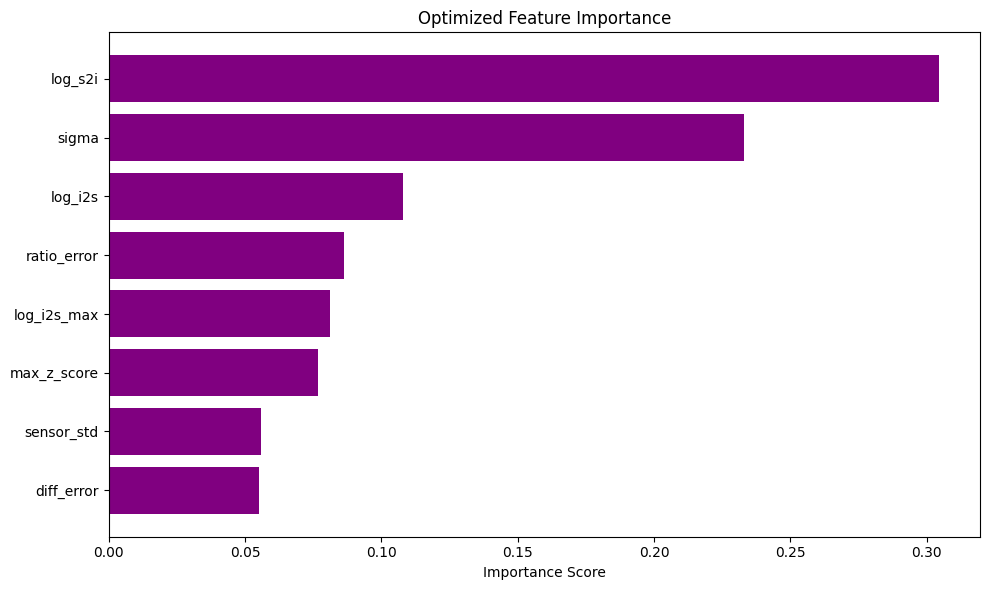

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. 데이터 로드
try:
    df = pd.read_csv("cross_modal_results.csv")
except FileNotFoundError:
    print("❌ Error: 'cross_modal_results.csv' not found. Please run the extraction code first.")
    exit()

# 2. 피처 엔지니어링 (8개 피처)
# 로그 변환 시 0이 있을 수 있으므로 np.log1p 사용
df['log_i2s'] = np.log1p(df['i2s_mse'])
df['log_s2i'] = np.log1p(df['s2i_mse'])
df['log_i2s_max'] = np.log1p(df['i2s_max_error']) # [New]
df['diff_error'] = df['log_i2s'] - df['log_s2i']
df['ratio_error'] = df['i2s_mse'] / (df['s2i_mse'] + 1e-6)

features = [
    'log_i2s', 'log_s2i', 'log_i2s_max',
    'diff_error', 'ratio_error',
    'max_z_score', 'sigma', 'sensor_std'
]

# 결측치 확인 및 처리 (안전을 위해)
X = df[features].fillna(0)
y = df['gt']

# 3. 데이터 분할 (50:50)
X_tune, X_eval, y_tune, y_eval = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

print(f"✂️ Data Split: Tuning={len(X_tune)}, Evaluation={len(X_eval)}")

# 4. Grid Search 설정
# 범위를 넓게 잡아서 최적점을 확실히 찾습니다.
param_grid = {
    'n_estimators': [200, 300, 500],      # 나무 개수: 많을수록 정교함
    'max_depth': [4, 6, 8, 10],           # 깊이: Case 1/3 구분을 위해 깊게 파봄
    'learning_rate': [0.01, 0.05, 0.1],   # 학습률: 작을수록 꼼꼼함
    'subsample': [0.8, 1.0],              # 데이터 샘플링: 과적합 방지
    'colsample_bytree': [0.8, 1.0],       # 피처 샘플링: 특정 피처 편향 방지
    'gamma': [0, 0.1, 0.2]                # 리프 노드 추가를 위한 최소 손실 감소값
}

xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1 # 병렬 처리
)

print("\n🔍 Starting Grid Search... (This may take a few minutes)")
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_tune, y_tune)

print(f"\n🏆 Best Parameters: {grid_search.best_params_}")
print(f"   Best CV Score (Tuning Set): {grid_search.best_score_:.2%}")

# 5. 최종 평가 (Evaluation Set)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_eval)

print("\n" + "="*60)
print("       [Grid Search Optimized] XGBoost Report")
print("="*60)
print(classification_report(y_eval, y_pred, target_names=['Normal', 'Case 1', 'Case 2', 'Case 3'], digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_eval, y_pred))
print(f"\n🔥 Final Accuracy: {accuracy_score(y_eval, y_pred):.2%}")

# 6. 피처 중요도 (최종)
plt.figure(figsize=(10, 6))
sorted_idx = best_model.feature_importances_.argsort()
plt.barh([features[i] for i in sorted_idx], best_model.feature_importances_[sorted_idx], color='purple')
plt.title("Optimized Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

## 이상 진단 리포트 생성

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import joblib
import json
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm

# [설정] 경로
REPORT_DIR = "/content/drive/MyDrive/anomaly_reports"
os.makedirs(REPORT_DIR, exist_ok=True)

TEST_DATA_PATH = "/content/preproc_test_data_final.xlsx"
SCALER_SAVE_PATH = "/content/drive/MyDrive/ResultCA/anp_scaler.joblib"
BEST_MODEL_SAVE_PATH = "/content/drive/MyDrive/ResultCA/best_cvae_anp_model.pth"

# XGBoost 관련 경로
XGB_MODEL_PATH = "/content/drive/MyDrive/VAE-ANP/final_models/xgboost_classifier_88acc.pkl"
FEATURE_CONFIG_PATH = "/content/drive/MyDrive/VAE-ANP/final_models/feature_config.json"
FEATURE_DATA_PATH = "cross_modal_results.csv" # Feature Extraction 단계에서 생성된 파일

# CVAE 모델 하이퍼파라미터
LATENT_DIM = 64; HIDDEN_DIM = 128; X_DIM = 2; BETA = 5.0; IMAGE_RESOLUTION = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("\n🚀 Setting up for Anomaly Reporting...")

# ====================================================
# [설정 및 상수]
# ====================================================
label_map = {0: 'Normal', 1: 'Case 1 (Mixed)', 2: 'Case 2 (Sensor)', 3: 'Case 3 (Visual)'}
COMPONENT_ORDER = ['MHS', 'R01', 'R02', 'R03', 'R04', 'Conv1', 'Conv2', 'Conv3', 'Conv4']

# 1. 센서-컴포넌트 매핑 함수 정의
def map_sensor_to_component(sensor_name):
    for component in sorted(COMPONENT_ORDER, key=len, reverse=True):
        if component in sensor_name: return component
    return 'Conv' if 'Conv' in sensor_name else None

COMPONENT_COORDS_0 = {
    'MHS': {'h': 53, 'w': 183, 'x1': 232, 'x2': 415, 'y1': 182, 'y2': 235},
    'R01': {'h': 160, 'w': 99, 'x1': 385, 'x2': 484, 'y1': 102, 'y2': 262},
    'R02': {'h': 148, 'w': 140, 'x1': 273, 'x2': 413, 'y1': 143, 'y2': 291},
    'R03': {'h': 187, 'w': 173, 'x1': 372, 'x2': 545, 'y1': 161, 'y2': 348},
    'R04': {'h': 139, 'w': 131, 'x1': 173, 'x2': 304, 'y1': 145, 'y2': 284},
    'Conv1': {'h': 158, 'w': 334, 'x1': 414, 'x2': 748, 'y1': 362, 'y2': 520},
    'Conv2': {'h': 139, 'w': 346, 'x1': 380, 'x2': 726, 'y1': 210, 'y2': 349},
    'Conv3': {'h': 43, 'w': 225, 'x1': 131, 'x2': 356, 'y1': 228, 'y2': 271},
    'Conv4': {'h': 294, 'w': 380, 'x1': 91, 'x2': 471, 'y1': 268, 'y2': 562}
}
COMPONENT_COORDS_1 = {
    'MHS': {'h': 251, 'w': 397, 'x1': 363, 'x2': 760, 'y1': 278, 'y2': 529},
    'R01': {'h': 439, 'w': 227, 'x1': 199, 'x2': 426, 'y1': 124, 'y2': 563},
    'R02': {'h': 187, 'w': 128, 'x1': 379, 'x2': 507, 'y1': 108, 'y2': 295},
    'R03': {'h': 148, 'w': 120, 'x1': 287, 'x2': 407, 'y1': 106, 'y2': 254},
    'R04': {'h': 264, 'w': 268, 'x1': 589, 'x2': 857, 'y1': 164, 'y2': 428},
    'Conv1': {'h': 39, 'w': 183, 'x1': 179, 'x2': 362, 'y1': 178, 'y2': 217},
    'Conv2': {'h': 182, 'w': 301, 'x1': 168, 'x2': 469, 'y1': 208, 'y2': 390},
    'Conv3': {'h': 81, 'w': 215, 'x1': 457, 'x2': 672, 'y1': 264, 'y2': 345},
    'Conv4': {'h': 106, 'w': 338, 'x1': 354, 'x2': 692, 'y1': 173, 'y2': 279}
}

# ====================================================
# 1. CVAE-ANP 환경 설정 (Scaler & Model)
# ====================================================
if os.path.exists(SCALER_SAVE_PATH):
    scaler_info = joblib.load(SCALER_SAVE_PATH)
    scaler = scaler_info['scaler']
    sensor_keys = scaler_info['valid_sensor_keys']
    print(f"✅ Loaded Scaler & {len(sensor_keys)} Sensor Keys.")
else:
    raise FileNotFoundError(f"❌ Scaler file not found: {SCALER_SAVE_PATH}")

# SENSOR_MAP 생성 (scaler 로드 후)
SENSOR_MAP = {key: map_sensor_to_component(key) for key in sensor_keys}

coord_0 = create_sensor_coord_tensor(sensor_keys, 0)
coord_1 = create_sensor_coord_tensor(sensor_keys, 1)

model = AttentiveCVAEANP(cvae_latent_dim=LATENT_DIM, condition_dim=2, x_dim=X_DIM,
                         hidden_dim=HIDDEN_DIM, anp_latent_dim=LATENT_DIM,
                         beta=BETA, img_size=IMAGE_RESOLUTION, min_std=0.01, dropout=0.2).to(DEVICE)

if os.path.exists(BEST_MODEL_SAVE_PATH):
    model.load_state_dict(torch.load(BEST_MODEL_SAVE_PATH, map_location=DEVICE))
    print(f"✅ Loaded CVAE-ANP Weights")
else:
    raise FileNotFoundError(f"❌ Model weights not found: {BEST_MODEL_SAVE_PATH}")

# ====================================================
# 2. 테스트 데이터셋 준비
# ====================================================
print("\n⏳ Loading TEST Data...")
try:
    test_raw_df = pd.read_excel(TEST_DATA_PATH)
    # 이미지 경로 설정 (테스트용 폴더)
    global IMG_DIRS
    IMG_DIRS = [
        "/content/Final/Image/test/BATCH24000",
        "/content/Final/Image/test/BATCH71000",
        "/content/Final/Image/test/BATCH72000"
    ]
except FileNotFoundError:
    print(f"❌ Error: Test 데이터 파일 없음: {TEST_DATA_PATH}")
    exit()

test_df_processed, test_mask = process_validation_data(test_raw_df, scaler_info, sensor_keys)
test_features_np = test_df_processed[sensor_keys].to_numpy(dtype=np.float32)

test_dataset = CombinedANPDataset(
    test_features_np,
    test_mask,
    test_raw_df['Images'],
    test_raw_df['label'],
    coord_0,
    coord_1,
    num_context_range=(10, 50),
    is_train=False
)

# ====================================================
# 3. XGBoost 추론 및 결과 저장
# ====================================================
print("\n🔮 Running XGBoost Classification...")

# 3-1. Feature 파일 확인
if not os.path.exists(FEATURE_DATA_PATH):
    # 이름이 다를 수 있으므로 체크
    if os.path.exists("cross_modal_results_final.csv"):
        FEATURE_DATA_PATH = "cross_modal_results_final.csv"
    else:
        raise FileNotFoundError(f"❌ Feature CSV not found. Please run feature extraction first.")

df_features = pd.read_csv(FEATURE_DATA_PATH)

# 3-2. XGBoost 모델 로드
if not os.path.exists(XGB_MODEL_PATH) or not os.path.exists(FEATURE_CONFIG_PATH):
    raise FileNotFoundError("❌ XGBoost model or config file missing.")

xgb_model = joblib.load(XGB_MODEL_PATH)
with open(FEATURE_CONFIG_PATH, 'r') as f:
    feat_config = json.load(f)

features_used = feat_config['features']
print(f"✅ Loaded XGBoost. Using features: {features_used}")

# 3-3. Feature Engineering (학습 때와 동일하게)
df_features['log_i2s'] = np.log1p(df_features['i2s_mse'])
df_features['log_s2i'] = np.log1p(df_features['s2i_mse'])
df_features['log_i2s_max'] = np.log1p(df_features['i2s_max_error'])
df_features['diff_error'] = df_features['log_i2s'] - df_features['log_s2i']
df_features['ratio_error'] = df_features['i2s_mse'] / (df_features['s2i_mse'] + 1e-6)

# 3-4. 예측 수행
X_test = df_features[features_used].fillna(0)
y_pred = xgb_model.predict(X_test)

# 3-5. 결과 저장
df_features['pred'] = y_pred
df_features.to_csv("xgb_classification_results.csv", index=True)
print(f"💾 Classification results saved. Found {len(df_features[df_features['pred'] != 0])} anomalies.")

# ====================================================
# 4. 추론 및 데이터 추출 함수 (에러 방지 강화)
# ====================================================
def get_cvae_anp_output(model, dataset, data_index, device):
    model.eval()
    sample = dataset[data_index]
    if sample is None: return None

    batch = collate_fn([sample])
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch[key] = batch[key].to(device)

    # 입력 준비
    full_x = torch.cat((batch['num_context_x'], batch['img_context_x']), dim=1)
    full_y = torch.cat((batch['num_context_y'], batch['img_context_y']), dim=1)
    condition = torch.cat([batch['label'].unsqueeze(1), batch['sensor_summary']], dim=1)

    # [Cross-Modal Inference]
    # 1. S2I Reconstruction (Sensor -> Image)
    # 2. I2S Prediction (Image -> Sensor)
    with torch.no_grad():
        # --- I2S: Image Context Only ---
        batch_size = batch['image'].shape[0]
        empty_ctx_x = torch.zeros((batch_size, 1, full_x.shape[-1]), device=device)
        empty_ctx_y = torch.zeros((batch_size, 1, 1), device=device)
        dummy_cond = torch.zeros_like(condition)

        returns = model(
            batch['image'], dummy_cond, empty_ctx_x, empty_ctx_y, full_x, target_y=None
        )
        y_dist = returns[0]
        image_cross_attn = returns[4]

        # --- S2I: Sensor Condition Only ---
        z_zero = torch.zeros((batch_size, model.cvae.latent_dim), device=device)
        recon_img_tensor = model.cvae.decode(z_zero, condition)

        # 센서 오차 계산 (I2S)
        pred_sensor_mean = y_dist.loc
        pred_sensor_std = y_dist.scale

        # (Batch, Seq, 1) -> (Seq,)
        sensor_errors = torch.abs(full_y - pred_sensor_mean).squeeze(-1).cpu().numpy()[0]
        sensor_uncertainty = pred_sensor_std.squeeze(-1).cpu().numpy()[0]
        actual_deltas = full_y.squeeze(-1).cpu().numpy()[0]
        predicted_deltas = pred_sensor_mean.squeeze(-1).cpu().numpy()[0]

    # [수정] 어텐션 차원 에러 방지
    if image_cross_attn.dim() == 4:
        att_score = image_cross_attn.mean(dim=[0, 1, 3]).cpu().numpy()
    elif image_cross_attn.dim() == 3:
        att_score = image_cross_attn.mean(dim=[0, 2]).cpu().numpy()
    else:
        att_score = np.full((full_x.shape[1],), image_cross_attn.mean().item())

    # 좌표 매칭 및 파일 경로
    img_filename = dataset.samples[data_index]['img_filename']
    is_type_1 = img_filename.endswith('_1.png')
    ref_coords = dataset.x_all_1 if is_type_1 else dataset.x_all_0

    # full_x[0] (Seq, 2)
    num_scored = len(att_score)
    used_coords = full_x[0, :num_scored, :].to(device)

    dists = torch.cdist(used_coords, ref_coords.to(device))
    closest_indices = torch.argmin(dists, dim=1).cpu().numpy()
    active_names = [sensor_keys[i] for i in closest_indices]

    full_path = dataset.img_path_map.get(img_filename, img_filename)

    # 센서 상세 정보 딕셔너리 생성 (리포트용)
    sensor_detail = {}
    for i, name in enumerate(active_names):
        if i < len(sensor_errors):
            sensor_detail[name] = {
                'error': float(sensor_errors[i]),
                'actual_delta': float(actual_deltas[i]),
                'predicted_delta': float(predicted_deltas[i]),
                'predicted_std': float(sensor_uncertainty[i])
            }

    return {
        'recon_img': recon_img_tensor[0].cpu() if recon_img_tensor.dim() == 4 else recon_img_tensor.cpu(),
        'att_scores': att_score,
        'img_path': full_path,
        'active_sensors': active_names,
        'sensor_info': sensor_detail,
        'is_type_1': is_type_1
    }

# ====================================================
# 5. 리포트 생성 메인 루프
# ====================================================
print("\n🚀 Starting Report Generation Loop...")

MAX_REPORTS = 20
count = 0

# anomalies는 feature csv에서 로드된 것
anomalies = df_features[df_features['pred'] != 0]

for idx, row in anomalies.iterrows():
    try:
        # 1. XGBoost 판단 결과
        pred_label = int(row['pred'])

        # 2. CVAE-ANP 정밀 추론
        res = get_cvae_anp_output(model, test_dataset, idx, DEVICE)
        if res is None: continue

        case_name = label_map[pred_label]
        save_base = os.path.join(REPORT_DIR, f"Report_{idx}_{case_name.replace(' ', '_')}")

        # 타입에 맞는 좌표계 선택
        current_coords = COMPONENT_COORDS_1 if res['is_type_1'] else COMPONENT_COORDS_0

        print(f"[{count+1}] Generating: ID {idx} - {case_name}")

        # ---------------------------------------------------------
        # Case별 시각화 로직
        # ---------------------------------------------------------

        # Case 1, 2: 센서 중심 리포트 (generate_anomaly_report 호출)
        if pred_label in [1, 2]:
            # 막대그래프
            bar_img = create_top_sensors_barplot(res['active_sensors'], res['att_scores'])
            if bar_img: bar_img.save(f"{save_base}_Barplot.png")

            # 상세 리포트 이미지 (바운딩 박스 포함)
            # 에러가 가장 큰 Top 5 센서 추출
            sorted_sensors = sorted(res['sensor_info'].items(), key=lambda x: x[1]['error'], reverse=True)[:5]
            top_sensors_dict = dict(sorted_sensors)

            generate_anomaly_report(
                image_path=res['img_path'],
                component_coords=current_coords,
                high_error_sensors=top_sensors_dict,
                sensor_to_component_map=SENSOR_MAP,
                output_path=f"{save_base}_Info.png",
                case_type_str=case_name
            )

        # Case 1, 3: 이미지 중심 히트맵
        if pred_label in [1, 3]:
            create_reconstruction_heatmap(res['recon_img'], res['img_path'], f"{save_base}_Heatmap.png")

        count += 1
        if count >= MAX_REPORTS: break

    except Exception as e:
        print(f"⚠️ Error at index {idx}: {e}")
        # import traceback; traceback.print_exc()

print(f"\n✅ Finished! {count} reports saved in {REPORT_DIR}")


🚀 Setting up for Anomaly Reporting...
✅ Loaded Scaler & 47 Sensor Keys.
✅ Loaded CVAE-ANP Weights

⏳ Loading TEST Data...
Dataset initialized with 6000 samples.

🔮 Running XGBoost Classification...
✅ Loaded XGBoost. Using features: ['log_i2s', 'log_s2i', 'log_i2s_max', 'diff_error', 'ratio_error', 'max_z_score', 'sigma', 'sensor_std']
💾 Classification results saved. Found 3004 anomalies.

🚀 Starting Report Generation Loop...
[1] Generating: ID 1 - Case 1 (Mixed)
Saved anomaly report to /content/drive/MyDrive/anomaly_reports/Report_1_Case_1_(Mixed)_Info.png
  - Saved anomaly heatmap with colorbar to /content/drive/MyDrive/anomaly_reports/Report_1_Case_1_(Mixed)_Heatmap.png
[2] Generating: ID 2 - Case 1 (Mixed)
Saved anomaly report to /content/drive/MyDrive/anomaly_reports/Report_2_Case_1_(Mixed)_Info.png
  - Saved anomaly heatmap with colorbar to /content/drive/MyDrive/anomaly_reports/Report_2_Case_1_(Mixed)_Heatmap.png
[3] Generating: ID 3 - Case 1 (Mixed)
Saved anomaly report to /con

In [ ]:
import joblib
import json
import os

# 저장할 경로 설정
SAVE_DIR = "/content/drive/MyDrive/VAE-ANP/final_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1. 최적의 파라미터로 학습된 최종 모델 (Grid Search의 best_estimator_)
final_model = grid_search.best_estimator_

# 2. 모델 저장 (XGBoost)
joblib.dump(final_model, os.path.join(SAVE_DIR, "xgboost_classifier_88acc.pkl"))

# 3. 피처 리스트 저장 (나중에 순서 헷갈리지 않게)
# 모델을 쓸 때 이 순서대로 데이터를 넣어줘야 합니다.
feature_config = {
    "features": features,
    "description": "Final XGBoost model with Cross-Modal features",
    "accuracy": "88.07%"
}

with open(os.path.join(SAVE_DIR, "feature_config.json"), "w") as f:
    json.dump(feature_config, f, indent=4)

print(f"\n✅ All files saved in '{SAVE_DIR}/' directory:")
print(f"   1. xgboost_classifier_88acc.pkl (The Model)")
print(f"   2. feature_config.json (Feature List)")
print("\n🎉 Project Complete! Great Job!")


✅ All files saved in '/content/drive/MyDrive/VAE-ANP/final_models/' directory:
   1. xgboost_classifier_88acc.pkl (The Model)
   2. feature_config.json (Feature List)

🎉 Project Complete! Great Job!


# VAE-LSTM 훈련

## 모델 불러오기

In [ ]:
import sys

# project_root_path = '/content/drive/My Drive/my_project'
project_root_path = '/content/drive/My Drive/VAE-LSTM/' # VAE_ANP 폴더 자체가 sys.path에 추가되도록 수정

# sys.path에 경로 추가
if project_root_path not in sys.path:
    sys.path.append(project_root_path)
    print(f"'{project_root_path}' 경로가 sys.path에 추가되었습니다.")
else:
    print(f"'{project_root_path}' 경로는 이미 sys.path에 있습니다.")

# 추가된 경로 확인 (선택 사항)
print("Current sys.path:")
for p in sys.path:
    print(p)

'/content/drive/My Drive/VAE-LSTM/' 경로가 sys.path에 추가되었습니다.
Current sys.path:
/content
/env/python
/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/usr/local/lib/python3.12/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.12/dist-packages/IPython/extensions
/root/.ipython
/content/drive/My Drive/VAE_ANP/
/tmp/tmp5sifxfl_
/content/drive/My Drive/VAE-LSTM/


## 훈련

In [ ]:
import tensorflow as tf
import json
import os
import joblib

from models import VAELSTMModel
from data_loader import DataGenerator
from trainers import ModelTrainer
from sklearn.preprocessing import StandardScaler

def main():
    """
    Main function to run the training process.
    """
    # --- Configuration Loading ---
    config_path = '/content/drive/MyDrive/VAE-LSTM/NAB_config.json'

    try:
        with open(config_path, 'r') as f:
            config = json.load(f)
            print("Configuration loaded successfully.")
    except FileNotFoundError:
        print(f"Error: Configuration file not found at {config_path}")
        return

    # --- Define Data Paths ---
    train_excel_path = config['train_sensor_data_path']
    val_excel_path = config['val_sensor_data_path']
    train_image_dirs = config['train_image_dirs']
    val_image_dirs = config['val_image_dirs']

    # Create the result directory if it doesn't exist
    if not os.path.exists(config['result_dir']):
        os.makedirs(config['result_dir'])

    # --- Component Instantiation ---
    try:
        print("Creating data loaders...")
        train_data_loader = DataGenerator(config, excel_path=train_excel_path,
                                          image_dirs=train_image_dirs)

        # IMPORTANT: Use the scaler from the training data for the validation set
        val_data_loader = DataGenerator(config, excel_path=val_excel_path,
                                        image_dirs=val_image_dirs, scaler = train_data_loader.scaler)

        print("Data loaders created.")
    except (FileNotFoundError, KeyError) as e:
        print(f"Error: A data file was not found. Please check paths in config. Details: {e}")
        return

    # --- Model, Trainer, and Training ---
    input_dims = len(train_data_loader.feature_cols)
    model = VAELSTMModel(config, input_dims)
    print("Model created.")

    trainer = ModelTrainer(model, train_data_loader, val_data_loader, config)
    print("Trainer created.")

    # --- Start Training ---
    print("Starting training...")
    trainer.train()
    print("Training finished.")

    # --- Save Model and Scaler ---
    print("Saving model weights and scaler...")
    model_weights_path = os.path.join(config['result_dir'], 'best_model_vl.weights.h5') # Changed from .h5 to .weights.h5
    scaler_path = os.path.join(config['result_dir'], 'scaler_vl.pkl')

    # Build the model before saving weights
    try:
        dummy_batch = next(iter(train_data_loader.get_dataset()))
        model(dummy_batch[:2])
        model.save_weights(model_weights_path)
        joblib.dump(train_data_loader.scaler, scaler_path)
        print(f"Model weights saved to {model_weights_path}")
        print(f"Scaler saved to {scaler_path}")
    except Exception as e:
        print(f"An error occurred while saving the model or scaler: {e}")


if __name__ == '__main__':
    main()

Configuration loaded successfully.
Creating data loaders...
Creating image path map (recursive search)...
Found 38002 unique images in the provided directories.
Reading and preprocessing excel file: /content/preproc_train_data_final.xlsx
Applying 1st order difference (Delta) processing...
Fitting a new StandardScaler on normal data (after diff).
Applying StandardScaler to columns: 49
Number of Skip Image: 0
Successfully loaded 37662 sequences and images.

Creating image path map (recursive search)...
Found 6000 unique images in the provided directories.
Reading and preprocessing excel file: /content/preproc_val_data_final.xlsx
Applying 1st order difference (Delta) processing...
Applying StandardScaler to columns: 49
Number of Skip Image: 0
Successfully loaded 5964 sequences and images.

Data loaders created.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created.
Trainer created.
Starting training...
Epoch 1/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.44it/s, val_loss=50.9825]


Train Loss: 55.9218, Validation Loss: 50.9825
✅ Validation Loss improved from inf to 50.9825. Saving model...
Epoch 2/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.40it/s, val_loss=50.9528]


Train Loss: 54.4360, Validation Loss: 50.9528
✅ Validation Loss improved from 50.9825 to 50.9528. Saving model...
Epoch 3/50


Validating:  99%|█████████▉| 93/94 [00:37<00:00,  2.47it/s, val_loss=50.9689]


Train Loss: 54.6821, Validation Loss: 50.9689
⚠️ Validation Loss did not improve. (Wait: 1/5)
Epoch 4/50


Validating:  99%|█████████▉| 93/94 [00:37<00:00,  2.46it/s, val_loss=50.9787]


Train Loss: 54.9078, Validation Loss: 50.9787
⚠️ Validation Loss did not improve. (Wait: 2/5)
Epoch 5/50


Validating:  99%|█████████▉| 93/94 [00:37<00:00,  2.47it/s, val_loss=50.9679]


Train Loss: 54.7854, Validation Loss: 50.9679
⚠️ Validation Loss did not improve. (Wait: 3/5)
Epoch 6/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.44it/s, val_loss=50.9524]


Train Loss: 54.4951, Validation Loss: 50.9524
✅ Validation Loss improved from 50.9528 to 50.9524. Saving model...
Epoch 7/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.44it/s, val_loss=50.9385]


Train Loss: 54.3742, Validation Loss: 50.9385
✅ Validation Loss improved from 50.9524 to 50.9385. Saving model...
Epoch 8/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.44it/s, val_loss=50.9275]


Train Loss: 54.1758, Validation Loss: 50.9275
✅ Validation Loss improved from 50.9385 to 50.9275. Saving model...
Epoch 9/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.43it/s, val_loss=50.9206]


Train Loss: 54.1126, Validation Loss: 50.9206
✅ Validation Loss improved from 50.9275 to 50.9206. Saving model...
Epoch 10/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.42it/s, val_loss=50.9132]


Train Loss: 53.9698, Validation Loss: 50.9132
✅ Validation Loss improved from 50.9206 to 50.9132. Saving model...
Epoch 11/50


Validating:  99%|█████████▉| 93/94 [00:37<00:00,  2.46it/s, val_loss=50.9120]


Train Loss: 53.9658, Validation Loss: 50.9120
✅ Validation Loss improved from 50.9132 to 50.9120. Saving model...
Epoch 12/50


Validating:  99%|█████████▉| 93/94 [00:37<00:00,  2.46it/s, val_loss=50.9005]


Train Loss: 53.9600, Validation Loss: 50.9005
✅ Validation Loss improved from 50.9120 to 50.9005. Saving model...
Epoch 13/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.40it/s, val_loss=50.8959]


Train Loss: 53.8681, Validation Loss: 50.8959
✅ Validation Loss improved from 50.9005 to 50.8959. Saving model...
Epoch 14/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.43it/s, val_loss=50.8878]


Train Loss: 53.8294, Validation Loss: 50.8878
✅ Validation Loss improved from 50.8959 to 50.8878. Saving model...
Epoch 15/50


Validating:  99%|█████████▉| 93/94 [00:37<00:00,  2.45it/s, val_loss=50.8823]


Train Loss: 53.7440, Validation Loss: 50.8823
✅ Validation Loss improved from 50.8878 to 50.8823. Saving model...
Epoch 16/50


Validating:  99%|█████████▉| 93/94 [00:37<00:00,  2.46it/s, val_loss=50.8746]


Train Loss: 53.6900, Validation Loss: 50.8746
✅ Validation Loss improved from 50.8823 to 50.8746. Saving model...
Epoch 17/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.43it/s, val_loss=50.8717]


Train Loss: 53.6716, Validation Loss: 50.8717
✅ Validation Loss improved from 50.8746 to 50.8717. Saving model...
Epoch 18/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.41it/s, val_loss=50.8681]


Train Loss: 53.6796, Validation Loss: 50.8681
✅ Validation Loss improved from 50.8717 to 50.8681. Saving model...
Epoch 19/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.43it/s, val_loss=50.8633]


Train Loss: 53.6262, Validation Loss: 50.8633
✅ Validation Loss improved from 50.8681 to 50.8633. Saving model...
Epoch 20/50


Validating:  99%|█████████▉| 93/94 [00:37<00:00,  2.46it/s, val_loss=50.8673]


Train Loss: 53.6335, Validation Loss: 50.8673
⚠️ Validation Loss did not improve. (Wait: 1/5)
Epoch 21/50


Validating:  99%|█████████▉| 93/94 [00:37<00:00,  2.47it/s, val_loss=50.8660]


Train Loss: 53.6209, Validation Loss: 50.8660
⚠️ Validation Loss did not improve. (Wait: 2/5)
Epoch 22/50


Validating:  99%|█████████▉| 93/94 [00:37<00:00,  2.45it/s, val_loss=50.8582]


Train Loss: 53.5795, Validation Loss: 50.8582
✅ Validation Loss improved from 50.8633 to 50.8582. Saving model...
Epoch 23/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.44it/s, val_loss=50.8604]


Train Loss: 53.5763, Validation Loss: 50.8604
⚠️ Validation Loss did not improve. (Wait: 1/5)
Epoch 24/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.44it/s, val_loss=50.8544]


Train Loss: 53.5763, Validation Loss: 50.8544
✅ Validation Loss improved from 50.8582 to 50.8544. Saving model...
Epoch 25/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.43it/s, val_loss=50.8551]


Train Loss: 53.5529, Validation Loss: 50.8551
⚠️ Validation Loss did not improve. (Wait: 1/5)
Epoch 26/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.43it/s, val_loss=50.8543]


Train Loss: 53.5601, Validation Loss: 50.8543
✅ Validation Loss improved from 50.8544 to 50.8543. Saving model...
Epoch 27/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.42it/s, val_loss=50.8554]


Train Loss: 53.5348, Validation Loss: 50.8554
⚠️ Validation Loss did not improve. (Wait: 1/5)
Epoch 28/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.40it/s, val_loss=50.8513]


Train Loss: 53.5322, Validation Loss: 50.8513
✅ Validation Loss improved from 50.8543 to 50.8513. Saving model...
Epoch 29/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.41it/s, val_loss=50.8515]


Train Loss: 53.5234, Validation Loss: 50.8515
⚠️ Validation Loss did not improve. (Wait: 1/5)
Epoch 30/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.42it/s, val_loss=50.8513]


Train Loss: 53.5219, Validation Loss: 50.8513
⚠️ Validation Loss did not improve. (Wait: 2/5)
Epoch 31/50


Validating:  99%|█████████▉| 93/94 [00:39<00:00,  2.38it/s, val_loss=50.8498]


Train Loss: 53.5096, Validation Loss: 50.8498
✅ Validation Loss improved from 50.8513 to 50.8498. Saving model...
Epoch 32/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.41it/s, val_loss=50.8463]


Train Loss: 53.5091, Validation Loss: 50.8463
✅ Validation Loss improved from 50.8498 to 50.8463. Saving model...
Epoch 33/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.41it/s, val_loss=50.8483]


Train Loss: 53.5015, Validation Loss: 50.8483
⚠️ Validation Loss did not improve. (Wait: 1/5)
Epoch 34/50


Validating:  99%|█████████▉| 93/94 [00:37<00:00,  2.47it/s, val_loss=50.8479]


Train Loss: 53.4968, Validation Loss: 50.8479
⚠️ Validation Loss did not improve. (Wait: 2/5)
Epoch 35/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.40it/s, val_loss=50.8478]


Train Loss: 53.5048, Validation Loss: 50.8478
⚠️ Validation Loss did not improve. (Wait: 3/5)
Epoch 36/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.43it/s, val_loss=50.8466]


Train Loss: 53.4926, Validation Loss: 50.8466
⚠️ Validation Loss did not improve. (Wait: 4/5)
Epoch 37/50


Validating:  99%|█████████▉| 93/94 [00:38<00:00,  2.43it/s, val_loss=50.8471]


Train Loss: 53.4946, Validation Loss: 50.8471
⚠️ Validation Loss did not improve. (Wait: 5/5)

🛑 Early Stopping Triggered! Validation loss did not improve for 5 consecutive epochs.
Training stopped at Epoch 37.
Training finished.
Saving model weights and scaler...
Model weights saved to /content/drive/MyDrive/Result_VL/best_model_vl.weights.h5
Scaler saved to /content/drive/MyDrive/Result_VL/scaler_vl.pkl


## 테스트

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import os
import joblib
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 사용자 정의 모듈 (경로는 환경에 맞게 수정 필요)
from models import VAELSTMModel
from data_loader import DataGenerator

# ====================================================
# 1. Feature Extraction Function (Modified for tf.data.Dataset)
# ====================================================
def extract_vae_features(model, data_loader):
    print("🚀 [VAE-LSTM] Extracting features from Test Data (Sensor Only)...")

    results = {
        'i2s_mse': [],      # Sensor Reconstruction Error
        'i2s_max_error': [],# Sensor Max Reconstruction Error
        's2i_mse': [],      # [Dummy] Image Reconstruction Error (0으로 채움)
        'sigma': [],        # Latent Uncertainty
        'sensor_std': [],   # Input Sensor Std
        'max_z_score': [],  # Input Sensor Max Z
        'file_num': []      # For GT mapping
    }

    tf_dataset = data_loader.get_dataset()

    try:
        total_batches = len(data_loader.sequences) // data_loader.config['batch_size']
    except:
        total_batches = None

    for i, batch_data in tqdm(enumerate(tf_dataset), total=total_batches, desc="Processing Batches"):
        sensor_in, img_in, _, _ = batch_data

        # 모델 실행 (단일 출력: 센서 재구성)
        recon_sensor = model([sensor_in, img_in])

        # [중요] 모델이 리스트가 아니라 텐서 하나만 반환한다고 가정
        if isinstance(recon_sensor, list):
             recon_sensor = recon_sensor[0]

        # 1. Sensor Reconstruction Error 계산
        sensor_diff = np.square(sensor_in.numpy() - recon_sensor.numpy())
        i2s_mse_batch = np.mean(sensor_diff, axis=(1, 2))
        i2s_max_batch = np.max(sensor_diff, axis=(1, 2))

        # 2. Image Reconstruction Error (계산 불가 -> 0으로 채움)
        # MobileNetV2는 인코더이므로 이미지를 복원하지 않음
        s2i_mse_batch = np.zeros(len(sensor_in))

        # 3. 기타 통계량
        if hasattr(model, 'code_std_dev'):
            sigma_batch = np.mean(model.code_std_dev.numpy(), axis=1)
        else:
            sigma_batch = np.zeros(len(sensor_in))

        sensor_std_batch = np.std(sensor_in.numpy(), axis=(1, 2))
        max_z_batch = np.max(np.abs(sensor_in.numpy()), axis=(1, 2))

        # 결과 저장
        results['i2s_mse'].extend(i2s_mse_batch)
        results['i2s_max_error'].extend(i2s_max_batch)
        results['s2i_mse'].extend(s2i_mse_batch) # 0 저장
        results['sigma'].extend(sigma_batch)
        results['sensor_std'].extend(sensor_std_batch)
        results['max_z_score'].extend(max_z_batch)

        current_batch_size = len(sensor_in)
        current_count = len(results['file_num'])
        results['file_num'].extend(range(current_count + 1, current_count + current_batch_size + 1))

    return pd.DataFrame(results)

# ====================================================
# 2. Main Execution
# ====================================================
def main():
    # --- A. Configuration & Setup ---
    config_path = '/content/drive/MyDrive/VAE-LSTM/NAB_config.json'
    try:
        with open(config_path, 'r') as f: config = json.load(f)
    except FileNotFoundError:
        print("❌ Config file not found."); return

    result_dir = config['result_dir']
    scaler_path = os.path.join(result_dir, 'scaler_vl.pkl')
    weights_path = os.path.join(result_dir, 'best_model_vl.weights.h5')
    csv_path = "vae_lstm_final_results.csv"

    # --- B. Load Model & Data ---
    print("⏳ Loading Scaler and Model...")
    try:
        scaler = joblib.load(scaler_path)
    except:
        print("❌ Scaler not found. Train the model first!"); return

    test_excel = config.get('test_sensor_data_path', config['val_sensor_data_path'])
    test_img_dirs = config.get('test_image_dirs', config['val_image_dirs'])

    # [수정] shuffle 인자 제거 (DataGenerator __init__에 없음)
    test_loader = DataGenerator(config, excel_path=test_excel,
                                image_dirs=test_img_dirs,
                                scaler=scaler)

    input_dims = len(test_loader.feature_cols)
    model = VAELSTMModel(config, input_dims)

    print("⏳ Building model with dummy data...")
    try:
        # [수정 핵심 3] get_dataset()을 호출하여 데이터셋을 가져온 뒤, take(1)로 1배치만 가져옴
        tf_dataset = test_loader.get_dataset()

        # take(1)은 데이터셋에서 배치 하나만 가져옵니다.
        for batch in tf_dataset.take(1):
            sensor_in, img_in, _, _ = batch # (sensor, image, len, label) 언패킹
            model([sensor_in, img_in])      # 모델 빌드 (Build)
            break                           # 한 번만 하고 탈출

        model.load_weights(weights_path)
        print("✅ Model loaded successfully.")
    except Exception as e:
        print(f"❌ Failed to build model or load weights: {e}")
        import traceback
        traceback.print_exc()
        return

    # --- C. Extract Features & Add GT & Save ---
    # 1. 피처 추출
    df = extract_vae_features(model, test_loader)

    # 2. GT(정답) 복사
    try:
        cvae_res = pd.read_csv("cross_modal_results.csv")
        # 데이터 개수가 다를 수 있으므로 길이에 맞춰 자르거나 경고 출력
        if len(df) <= len(cvae_res):
            df['gt'] = cvae_res['gt'][:len(df)]
            print("✅ Copied GT labels from CVAE-ANP results.")
        else:
            print(f"⚠️ Length mismatch (CVAE:{len(cvae_res)} vs VAE:{len(df)}). Cannot copy GT safely.")
            df['gt'] = 0
    except FileNotFoundError:
        print("⚠️ 'cross_modal_results.csv' not found. Cannot load GT.")
        return

    # 3. CSV 파일로 저장
    df.to_csv(csv_path, index=False)
    print(f"✅ Features saved to '{csv_path}'")

    # --- D. XGBoost Training & Grid Search ---
    print("\n🚀 Starting XGBoost Grid Search...")

    # --------------------------------------------------------
    # [추가] 여기서부터가 생략되었던 XGBoost 핵심 로직입니다.
    # --------------------------------------------------------

    # 1. 피처 엔지니어링 (로그 변환 및 파생 변수 생성)
    # i2s_mse(센서 복원 오차)는 중요하지만, s2i_mse(이미지 복원 오차)는 0이므로 의미 없음
    # 하지만 CVAE-ANP와의 형평성을 위해 동일한 컬럼 구조를 유지합니다.
    df['log_i2s'] = np.log1p(df['i2s_mse'])
    df['log_s2i'] = np.log1p(df['s2i_mse']) # 0 -> 0
    df['log_i2s_max'] = np.log1p(df['i2s_max_error'])

    df['diff_error'] = df['log_i2s'] - df['log_s2i']
    df['ratio_error'] = df['i2s_mse'] / (df['s2i_mse'] + 1e-6)

    features = [
        'log_i2s', 'log_s2i', 'log_i2s_max',
        'diff_error', 'ratio_error',
        'max_z_score', 'sigma', 'sensor_std'
    ]

    # 결측치 처리 (0으로 채움)
    X = df[features].fillna(0)
    y = df['gt'] # Ground Truth

    # 2. 데이터 분할 (Tuning 50% / Evaluation 50%)
    # stratify=y 옵션으로 클래스 비율을 유지하며 나눔
    try:
        X_tune, X_eval, y_tune, y_eval = train_test_split(
            X, y, test_size=0.5, random_state=42, stratify=y
        )
        print(f"✂️ Data Split: Tuning={len(X_tune)}, Evaluation={len(X_eval)}")
    except ValueError as e:
        print(f"❌ Error during split: {e}")
        print("데이터 개수가 너무 적거나 클래스 불균형이 심할 수 있습니다.")
        return

    # 3. Grid Search 설정
    param_grid = {
        'n_estimators': [200, 300],
        'max_depth': [4, 6, 8, 10],
        'learning_rate': [0.05, 0.1],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1]
    }

    xgb = XGBClassifier(
        objective='multi:softmax',
        num_class=4,
        random_state=42,
        eval_metric='mlogloss',
        n_jobs=-1
    )

    print("🔍 [VAE-LSTM] Starting Grid Search...")
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_tune, y_tune)

    print(f"\n🏆 Best Parameters: {grid_search.best_params_}")
    print(f"   Best CV Score (Tuning Set): {grid_search.best_score_:.2%}")

    # 4. 최종 평가 (Evaluation Set)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_eval)

    print("\n" + "="*60)
    print("       [VAE-LSTM] Final XGBoost Evaluation Report")
    print("="*60)
    # digits=4를 주어 소수점 4자리까지 출력
    print(classification_report(y_eval, y_pred, target_names=['Normal', 'Case 1', 'Case 2', 'Case 3'], digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_eval, y_pred))

    acc = accuracy_score(y_eval, y_pred)
    print(f"\n🔥 Final Accuracy: {acc:.2%}")

    # 5. 결과 비교 멘트 (CVAE-ANP 점수와 비교)
    try:
        # 이 값은 CVAE-ANP 실험에서 나온 정확도를 직접 적어주거나 로드해야 합니다.
        cvae_acc = 0.8807

        print("\n" + "-"*60)
        print("📊 [Comparison Summary]")
        print(f"   CVAE-ANP Accuracy: {cvae_acc:.2%}")
        print(f"   VAE-LSTM Accuracy: {acc:.2%}")

        if cvae_acc > acc:
            diff = cvae_acc - acc
            print(f"✅ Proposed model (CVAE-ANP) outperforms VAE-LSTM by {diff*100:.2f}%p!")
        else:
            print(f"⚠️ VAE-LSTM is comparable or better.")
    except:
        pass

if __name__ == '__main__':
    main()

⏳ Loading Scaler and Model...
Creating image path map (recursive search)...
Found 6000 unique images in the provided directories.
Reading and preprocessing excel file: /content/preproc_test_data_final.xlsx
Applying 1st order difference (Delta) processing...
Applying StandardScaler to columns: 49
Number of Skip Image: 0
Successfully loaded 5804 sequences and images.

⏳ Building model with dummy data...
✅ Model loaded successfully.
🚀 [VAE-LSTM] Extracting features from Test Data (Sensor Only)...


Processing Batches: 100%|██████████| 90/90 [00:25<00:00,  3.52it/s]

✅ Copied GT labels from CVAE-ANP results.
✅ Features saved to 'vae_lstm_final_results.csv'

🚀 Starting XGBoost Grid Search...
✂️ Data Split: Tuning=2880, Evaluation=2880
🔍 [VAE-LSTM] Starting Grid Search...
Fitting 3 folds for each of 64 candidates, totalling 192 fits



🏆 Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}
   Best CV Score (Tuning Set): 67.92%

       [VAE-LSTM] Final XGBoost Evaluation Report
              precision    recall  f1-score   support

      Normal     0.7776    0.8647    0.8188      1500
      Case 1     0.6417    0.5660    0.6015       500
      Case 2     0.6265    0.5200    0.5683       500
      Case 3     0.6011    0.5632    0.5815       380

    accuracy                         0.7132      2880
   macro avg     0.6617    0.6285    0.6425      2880
weighted avg     0.7045    0.7132    0.7063      2880

Confusion Matrix:
 [[1297   43  118   42]
 [  95  283   28   94]
 [ 211   23  260    6]
 [  65   92    9  214]]

🔥 Final Accuracy: 71.32%

------------------------------------------------------------
📊 [Comparison Summary]
   CVAE-ANP Accuracy: 88.07%
   VAE-LSTM Accuracy: 71.32%
✅ Proposed model (CVAE-ANP) outperforms VAE-LSTM by 16.75%p!
